In [1]:
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
from shutil import copyfile
rcParams['figure.figsize'] = 25, 10
import numpy as np 
import random 
import datetime
import os 
import dill as pickle
import pandas as pd

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.otherfunctions.multiplot import highlight_cell
from codes.experimentclasses.EthanolAngles import EthanolAngles
from codes.otherfunctions.multirun import get_coeffs_reps
#from codes.otherfunctions.multirun import get_grads_reps_pca2
from codes.otherfunctions.multiplot import plot_betas, plot_betas2reorder
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multirun import get_cosines
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from einops import rearrange


/Users/samsonkoelle/manifoldflasso_jmlr


In [2]:

#set parameters
n = 50000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 1. #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])

#these are just for loading... probably not necessary
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)
nreps = 25
lambda_max = 1
max_search = 30

#folder = workingdirectory + '/Figures/malonaldehyde/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
#os.mkdir(folder)

#src = workingdirectory + '/codes/experiments/malonaldehyde_110120_nsel100_nreps25.py'
#filenamescript = folder + '/script.py'
#copyfile(src, filenamescript)

new_MN = True
new_grad = True
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'

new_MN = True
new_grad = True
if new_MN == True:
    experiment = EthanolAngles(dim,  ii, jj,cores,atoms4)
    projector  = np.load(data_wd + '/untracked_data/chemistry_data/ethanolangles022119_pca50_components.npy')
    experiment.M = experiment.load_data(workingdirectory = data_wd)  # if noise == False then noise parameters are overriden
    experiment.Mpca = RiemannianManifold(np.load(data_wd + '/untracked_data/chemistry_data/ethanolangles022119_pca50.npy'), dim)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.projector = projector
    experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
    experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)

In [3]:
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/ethanol_122620_pallrep5n100results.pkl' ,
         'rb') as loader:
     results = pickle.load(loader)
        
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/ethanol_122620_pallrep5n100replicates_small.pkl' ,
         'rb') as loader:
     replicates = pickle.load(loader)


In [6]:
atoms4

array([[6, 1, 0, 4],
       [4, 0, 2, 8],
       [7, 6, 5, 1],
       [3, 0, 2, 4]])

In [49]:
def cosine_similarity(a, b):
    output = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return (output)

def get_kappa_s(dg_M):
    n = dg_M.shape[0]
    d= dg_M.shape[1]
    p = dg_M.shape[2]
    maxes = np.zeros(n)
    #coses_zerodiag = coses.copy()
    kappa_ij= np.zeros((n,p))
    for i in range(n):
        kappa_ij[i] = np.linalg.norm(dg_M[i], axis = 0)
    kappa_i = np.max(kappa_ij, axis = 1) / np.min(kappa_ij, axis = 1)
    kappa = np.max(kappa_i)    
    return(kappa)

def get_coses_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                if ind[j] != k:
                    coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)

def get_mu_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                if ind[j] != k:
                    coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses.max())

def get_min_min(dg_M):
    n = dg_M.shape[0]
    d= dg_M.shape[1]
    p = dg_M.shape[2]
    maxes = np.zeros(n)
    #coses_zerodiag = coses.copy()
    kappa_ij= np.zeros((n,p))
    for i in range(n):
        kappa_ij[i] = np.linalg.norm(dg_M[i], axis = 0)
    min_min = np.min(kappa_ij)
    return(min_min)

def get_gamma_max(dg_M):
    output = np.sum(np.sum(dg_M**2, axis = 1), axis = 0).max()
    return(output)

# def get_cosines(self, dg):
def get_cosines_full(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    coses = np.zeros((n, p, p))
    for i in range(n):
        #print(i)
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)

def cosine_similarity(a, b):
    output = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return (output)

# def get_cosines(self, dg):
def get_cosines2(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]

    coses = np.zeros((n, p, p))
    for i in range(n):
        print(i)
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)
#coses = get_cosines2(np.swapaxes(replicates[0].dg_M,1,2))

def get_cosines(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]

    coses = np.zeros((n, p, p))
    for i in range(n):
        print(i)
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    cos_summary = np.sum(coses ** 2, axis=0) / n
    return (cos_summary)

In [5]:
r = 0 
dg_M = replicates[r].dg_M
#    mus[r] = get_mu_full_ind(np.swapaxes(dg_M,1,2)*n, inds)


In [12]:
np.linalg.norm(dg_M, axis = tuple([0,1])).argmax()

722

In [13]:
get_mu_full_ind(np.swapaxes(dg_M,1,2)*n, [722])

0.9999999996107063

In [ ]:
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)

In [4]:
a4, p = get_all_atoms_4(9)

In [14]:
mids = a4[:,[1,2]]

In [23]:
for i in range(mids.shape[0]):
    mids[i].sort()
    if (mids[i] == [0,2]).all():
        print(a4[i], i )

[1 0 2 3] 1
[1 0 2 4] 7
[1 0 2 5] 13
[1 0 2 6] 19
[1 0 2 7] 25
[1 0 2 8] 31
[4 2 0 3] 128
[5 2 0 3] 134
[6 2 0 3] 140
[7 2 0 3] 146
[8 2 0 3] 152
[5 2 0 4] 158
[6 2 0 4] 164
[7 2 0 4] 170
[8 2 0 4] 176
[6 2 0 5] 182
[7 2 0 5] 188
[8 2 0 5] 194
[7 2 0 6] 200
[8 2 0 6] 206
[8 2 0 7] 212


In [20]:
a4[74],a4[176]

array([6, 1, 0, 4])

array([8, 2, 0, 4])

In [64]:
experiment.atoms4 = a4[[196,721,722],:]

experiment.atoms4 = a4[[196,721,722, 746, 584, 662],:]

In [65]:
experiment.p = 3
experiment.p = 6

In [66]:

def get_grads(experiment, Mpca, Mangles, N, selected_points):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    #df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    #df_M2 = df_M / np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5)
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([np.matmul(experiment.projector, dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = experiment.project(subM.tb.tangent_bases, dgw_norm)
    return(dg_M)


In [72]:
res = results[0]

In [79]:
output = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, list(range(500)))

In [81]:
coses = get_cosines_full(output)

In [82]:
coses.shape

(500, 6, 6)

In [93]:
g1 = experiment.get_g_full_sub(experiment.M.data, a4[722])
g2 = experiment.get_g_full_sub(experiment.M.data, a4[584])


In [134]:
g2 = experiment.get_g_full_sub(experiment.M.data, a4[234])


In [139]:
g2.min()

0.016709927800640584

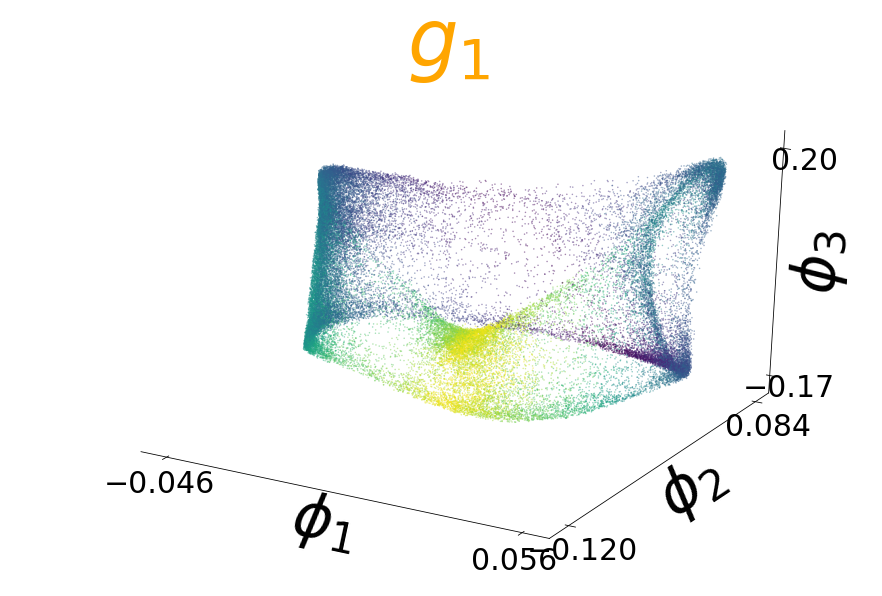

In [94]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_groundtruth_g1')

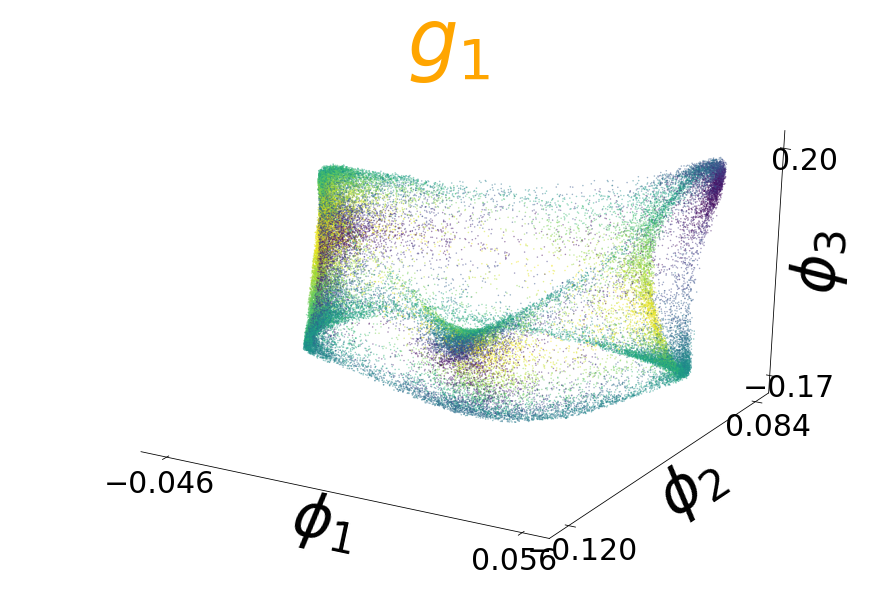

In [95]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g2, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_groundtruth_g1')

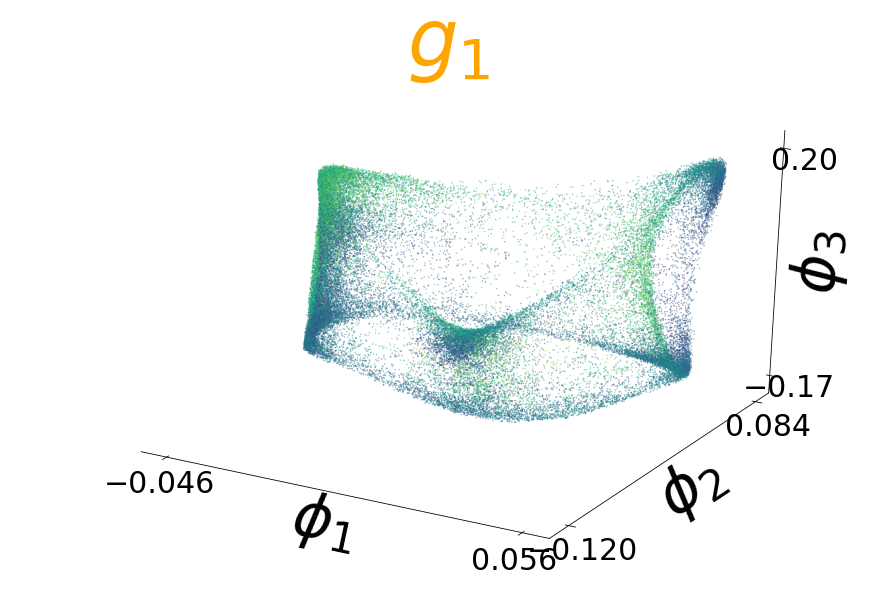

In [141]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g2, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi/2)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_groundtruth_g1')

In [20]:
#output[:,0,1]

In [101]:
c = np.abs(coses[:,2,4])

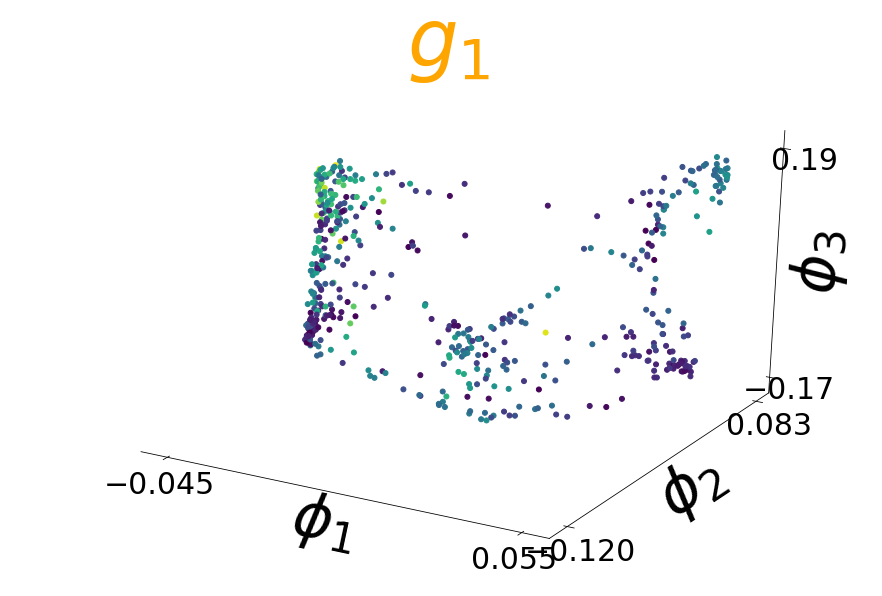

In [102]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = 1

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = 1.
#selected_points = list(range(50000))
selected_points = list(range(500))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = c, s=s, alpha=alpha, marker='.',vmin=0,vmax=1.)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_groundtruth_g1')

In [88]:
c = np.abs(coses[:,0,1])

In [89]:
selected_points = list(range(500))

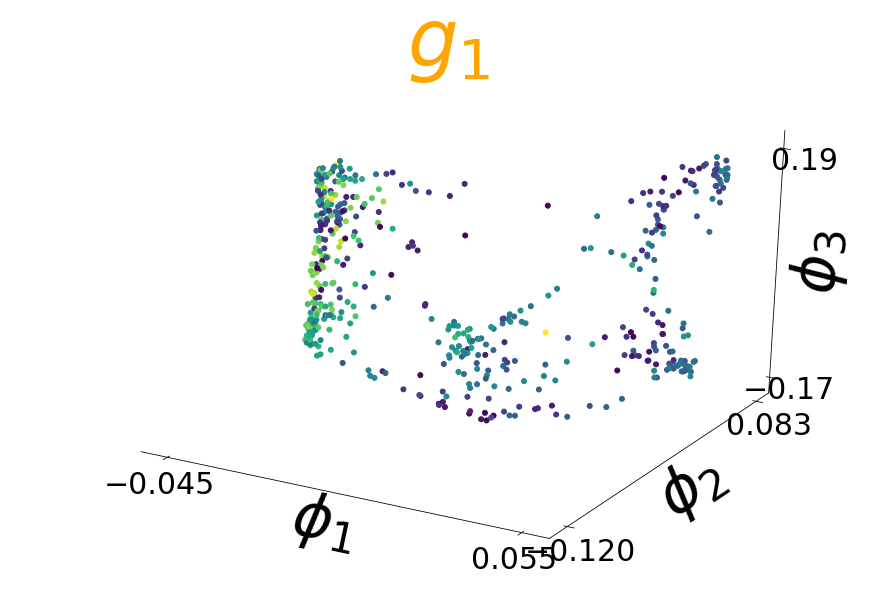

In [90]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = 1

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = 1.
#selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = c, s=s, alpha=alpha, marker='.',vmin=0,vmax=1.)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_groundtruth_g1')

In [49]:
c = np.abs(coses[:,2,1])

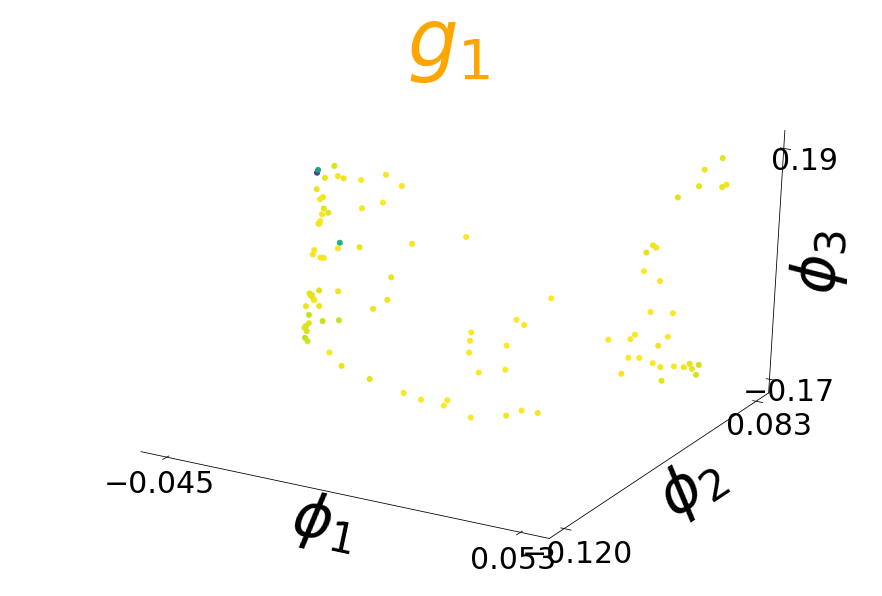

In [50]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = 1

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = 1.
#selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = c, s=s, alpha=alpha, marker='.',vmin=0,vmax=1.)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_groundtruth_g1')

In [117]:
def get_cos_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                #if ind[j] != k:
                coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    
    return (coses)


In [199]:
def get_incoherent_dictionary_include(dg_M, thresh, include):
    
    incoherent_indices = include

    #dg_M_down = 
    keepers = np.asarray(list(range(dg_M.shape[2])))
    coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, include)#**2
    print(coses.shape)
    cos_mean = coses.mean(axis = 0).max(axis = 0)
    keepers = np.where(np.abs(cos_mean) < thresh)[0]
    
    for i in range(dg_M.shape[2]):
        #print(i)
        id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        ind_add = keepers[id_add]
        incoherent_indices = np.append(incoherent_indices, ind_add)
        
        #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        #coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]
        coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])#**2
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        keepers = keepers[np.where(np.abs(np.mean(coses, axis = 0)) < thresh)[1]]
        #print(keepers)
        if len(keepers) == 0:
            print(i)
            break
            
    return(np.asarray(incoherent_indices, dtype = int))

In [200]:
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/ethanol_122620_pallrep5n100results.pkl' ,
         'rb') as loader:
     results = pickle.load(loader)
        
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/ethanol_122620_pallrep5n100replicates_small.pkl' ,
         'rb') as loader:
     replicates = pickle.load(loader)


In [325]:
thresh = .2
incoherent_indices = {}
nreps = 1
for r in range(nreps):
    incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, thresh, include)
    #replicates[r].dg_M = replicates[r].dg_M[:,:,incoherent_indices[r]]

(100, 2, 756)
12


In [326]:
incoherent_indices

{0: array([ 74, 176, 722, 584, 567, 606, 564, 650, 665, 580, 653, 108, 339,
         90,  37])}

In [328]:
#selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
p = replicates[0].dg_M.shape[2]
lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100

In [329]:
#thresh = .8
#incoherent_indices = {}
#nreps = 5
for r in range(nreps):
    #incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, thresh, include)
    replicates[r].dg_M = replicates[r].dg_M[:,:,incoherent_indices[r]]
    p = np.asarray(incoherent_indices[r], dtype = int).shape[0]
    lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


initializing lambda search
0
lr 100
lr 50.0
lr 25.0
1
lr 25.0
lr 12.5
lr 6.25
2
lr 6.25
3
lr 6.25
4
lr 6.25
5
lr 6.25
6
lr 6.25
7
lr 6.25
8
lr 6.25
9
lr 6.25
10
lr 6.25
11
lr 6.25
12
lr 6.25
13
lr 6.25
14
lr 6.25
15
lr 6.25
16
lr 6.25
17
lr 6.25
18
lr 6.25
19
lr 6.25
20
lr 6.25
21
lr 6.25
22
lr 6.25
23
lr 6.25
24
lr 6.25
25
lr 6.25
26
lr 6.25
27
lr 6.25
28
lr 6.25
29
lr 6.25
30
lr 6.25
31
lr 6.25
32
lr 6.25
33
lr 6.25
34
lr 6.25
35
lr 6.25
36
lr 6.25
37
lr 6.25
38
lr 6.25
39
lr 6.25
40
lr 6.25
41
lr 6.25
42
lr 6.25
43
lr 6.25
44
lr 6.25
45
lr 6.25
46
lr 6.25
47
lr 6.25
48
lr 6.25
49
lr 6.25
50
lr 6.25
51
lr 6.25
52
lr 6.25
53
lr 6.25
54
lr 6.25
55
lr 6.25
56
lr 6.25
57
lr 6.25
58
lr 6.25
59
lr 6.25
60
lr 6.25
61
lr 6.25
62
lr 6.25
63
lr 6.25
64
lr 6.25
65
lr 6.25
66
lr 6.25
67
lr 6.25
68
lr 6.25
69
lr 6.25
70
lr 6.25
71
lr 6.25
72
lr 6.25
73
lr 6.25
74
lr 6.25
75
lr 6.25
76
lr 6.25
77
lr 6.25
78
lr 6.25
79
lr 6.25
80
lr 6.25
81
lr 6.25
82
lr 6.25
83
lr 6.25
84
lr 6.25
85
lr 6.25
86
lr 

lr 6.25
238
lr 6.25
239
lr 6.25
240
lr 6.25
241
lr 6.25
242
lr 6.25
243
lr 6.25
244
lr 6.25
245
lr 6.25
246
lr 6.25
247
lr 6.25
248
lr 6.25
249
lr 6.25
250
lr 6.25
251
lr 6.25
252
lr 6.25
253
lr 6.25
254
lr 6.25
255
lr 6.25
256
lr 6.25
257
lr 6.25
258
lr 6.25
259
lr 6.25
260
lr 6.25
261
lr 6.25
262
lr 6.25
263
lr 6.25
264
lr 6.25
265
lr 6.25
266
lr 6.25
267
lr 6.25
268
lr 6.25
269
lr 6.25
270
lr 6.25
271
lr 6.25
272
lr 6.25
273
lr 6.25
274
lr 6.25
275
lr 6.25
276
lr 6.25
277
lr 6.25
278
lr 6.25
279
lr 6.25
280
lr 6.25
281
lr 6.25
282
lr 6.25
283
lr 6.25
284
lr 6.25
285
lr 6.25
286
lr 6.25
287
lr 6.25
288
lr 6.25
289
lr 6.25
290
lr 6.25
291
lr 6.25
292
lr 6.25
293
lr 6.25
294
lr 6.25
295
lr 6.25
296
lr 6.25
297
lr 6.25
298
lr 6.25
299
lr 6.25
300
lr 6.25
301
lr 6.25
302
lr 6.25
303
lr 6.25
304
lr 6.25
305
lr 6.25
306
lr 6.25
307
lr 6.25
308
lr 6.25
309
lr 6.25
310
lr 6.25
311
lr 6.25
312
lr 6.25
313
lr 6.25
314
lr 6.25
315
lr 6.25
316
lr 6.25
317
lr 6.25
318
lr 6.25
319
lr 6.25
320
lr 6

lr 12.5
438
lr 12.5
439
lr 12.5
440
lr 12.5
441
lr 12.5
442
lr 12.5
443
lr 12.5
444
lr 12.5
445
lr 12.5
446
lr 12.5
447
lr 12.5
448
lr 12.5
449
lr 12.5
450
lr 12.5
451
lr 12.5
452
lr 12.5
453
lr 12.5
454
lr 12.5
455
lr 12.5
456
lr 12.5
457
lr 12.5
458
lr 12.5
459
lr 12.5
460
lr 12.5
461
lr 12.5
462
lr 12.5
463
lr 12.5
464
lr 12.5
465
lr 12.5
466
lr 12.5
467
lr 12.5
468
lr 12.5
469
lr 12.5
470
lr 12.5
471
lr 12.5
472
lr 12.5
473
lr 12.5
474
lr 12.5
475
lr 12.5
476
lr 12.5
477
lr 12.5
478
lr 12.5
479
lr 12.5
480
lr 12.5
481
lr 12.5
482
lr 12.5
483
lr 12.5
484
lr 12.5
485
lr 12.5
486
lr 12.5
487
lr 12.5
488
lr 12.5
489
lr 12.5
490
lr 12.5
491
lr 12.5
492
lr 12.5
493
lr 12.5
494
lr 12.5
495
lr 12.5
496
lr 12.5
497
lr 12.5
498
lr 12.5
499
lr 12.5
1 0.07745966692414834 probe
0
lr 100
lr 50.0
1
lr 50.0
2
lr 50.0
3
lr 50.0
lr 25.0
4
lr 25.0
5
lr 25.0
6
lr 25.0
7
lr 25.0
8
lr 25.0
9
lr 25.0
10
lr 25.0
11
lr 25.0
12
lr 25.0
13
lr 25.0
14
lr 25.0
15
lr 25.0
16
lr 25.0
17
lr 25.0
18
lr 25.0
19
lr 

In [330]:
nreps = 1
for r in range(nreps):
    #r = 0 
    cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis

#nreps = 5
sel_l = np.zeros(nreps, dtype = int)
for r in range(nreps):
    for l in range(replicates[r].cs_reorder.shape[0]):
        zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
        if len(zeros) == 2:
            sel_l[r] = l
            #print(np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[2] !=0.))

almost_sel = {}
sel = {}
for r in range(nreps):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    almost_sel[r] = zeros

In [331]:
#pretty slow
g_mf = np.zeros((5,2,50000))
for r in range(1):
    for o in range(2):
        #print(o)
        #g_mf[r,o] =  experiment.get_g_full_sub(experiment.M.data, atoms4[incoherent_indices[r][sel[r]][o]])
        print(a4[incoherent_indices[r][sel[r]][o]])

[8 6 3 7]
[6 2 8 7]


In [ ]:
#pretty slow
g_mf_inc2 = np.zeros((5,2,50000))
for r in range(1):
    for o in range(2):
        print(o)
        g_mf_inc2[r,o] =  experiment.get_g_full_sub(experiment.M.data, a4[incoherent_indices[r][sel[r]][o]])

0


In [ ]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,5, figsize = (30,15))

for r in range(5):
    for o in range(2):
        axs[o,r].set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(1):
    for o in range(2):
        ax = fig.add_subplot(2,5, o*5 + r + 1, projection='3d')
        #fig = plt.figure(figsize=(15,10))
        #ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.scatter(x, y, z, c = g_mf_inc2[r,o], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
        ax.set_xlabel(r'$\phi_1$', fontsize = 30)
        ax.set_ylabel(r'$\phi_2$', fontsize = 30)
        ax.set_zlabel(r'$\phi_3$', fontsize = 30)
        
        if o ==0:
            ax.set_title('Replicate ' + str(r+1) + '\n' + r'$g_{{{}}}$'.format(incoherent_indices[r][sel[r][0]]), fontsize = 30)
        if o == 1:
            ax.set_title(r'$g_{{{}}}$'.format(incoherent_indices[r][sel[r][1]]), fontsize = 30)
        #ax.set_axis_off()
        xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
        xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
        ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
        ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
        zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
        zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
        ax.set_xticks([xmin, xmax])
        ax.set_yticks([ymin, ymax])
        ax.set_zticks([zmin, zmax])
        ax.tick_params(labelsize=20)

        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_full_sup_mflasso')

In [219]:
#pretty slow
g_mf_inc = np.zeros((5,2,50000))
for r in range(1):
    for o in range(2):
        print(o)
        g_mf_inc[r,o] =  experiment.get_g_full_sub(experiment.M.data, a4[incoherent_indices[r][sel[r]][o]])

0
1


In [5]:
g1 = experiment.get_g_full_sub(experiment.M.data, a4[74])
g2 = experiment.get_g_full_sub(experiment.M.data, a4[176])

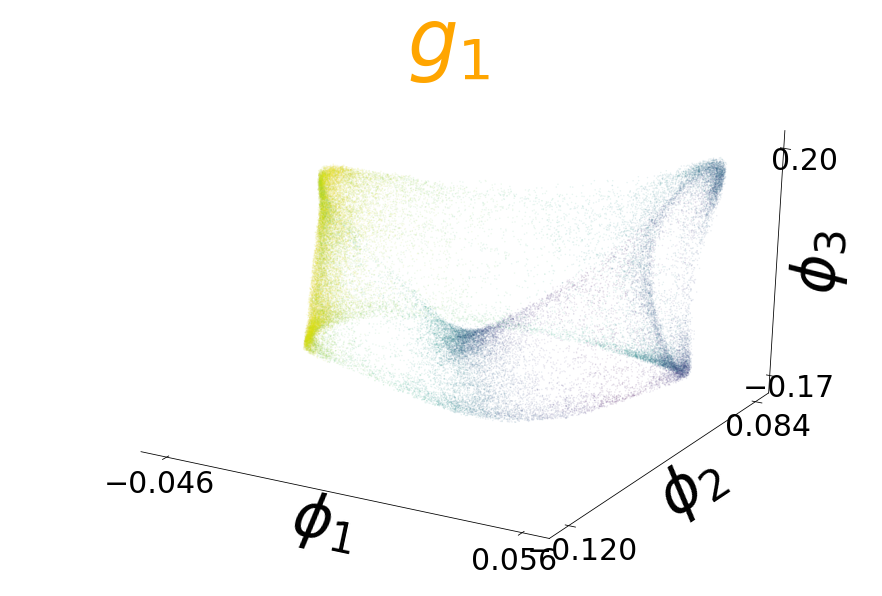

In [9]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = 1

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .1
#selected_points = list(range(50000))
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_groundtruth_g1')

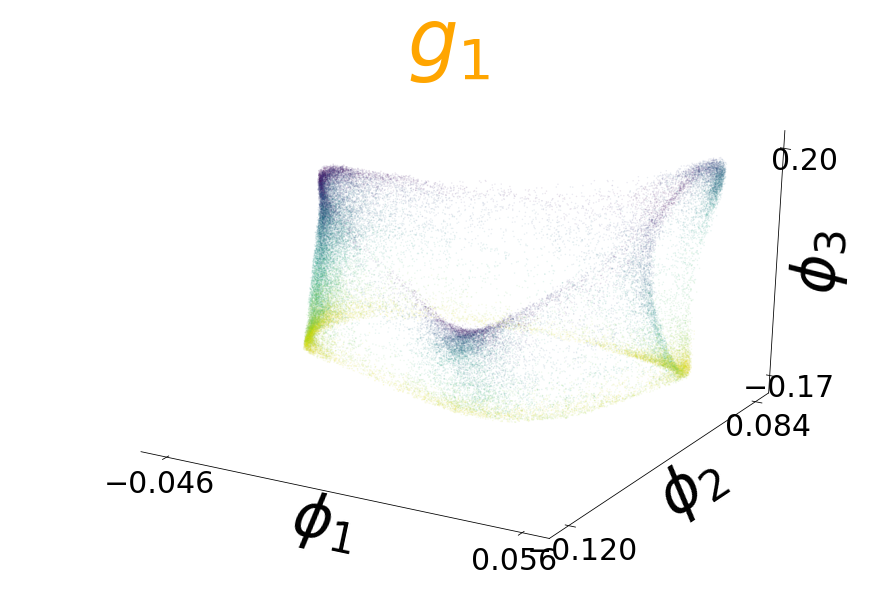

In [10]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = 1

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1.
alpha = .1
#selected_points = list(range(50000))
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g2, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_groundtruth_g1')

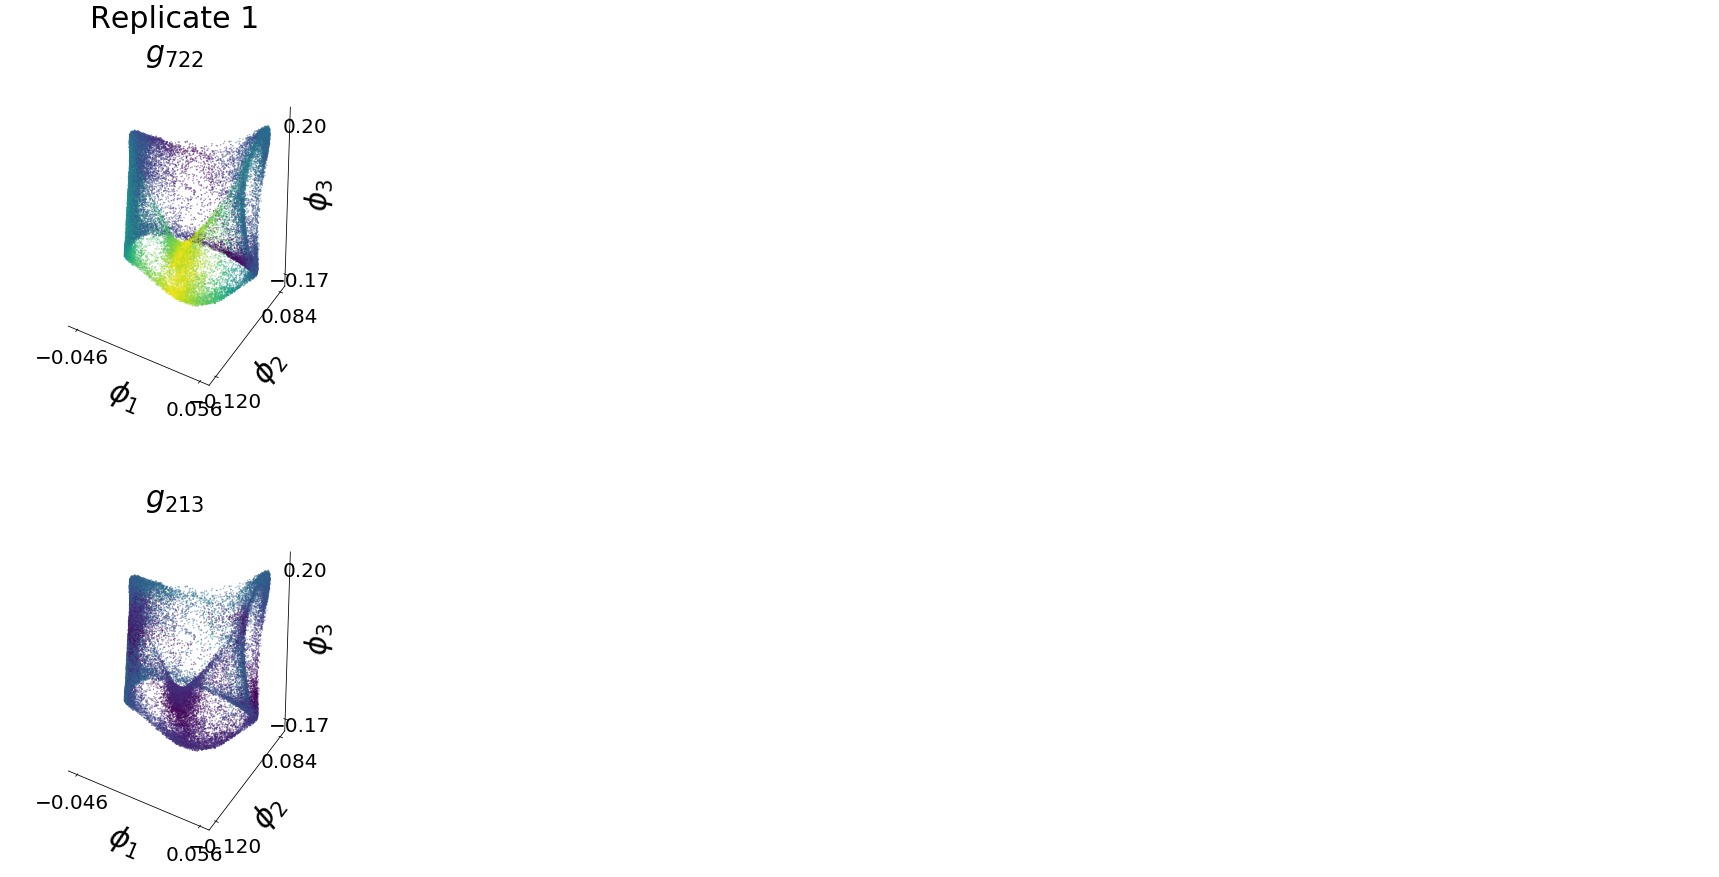

In [220]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,5, figsize = (30,15))

for r in range(5):
    for o in range(2):
        axs[o,r].set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(1):
    for o in range(2):
        ax = fig.add_subplot(2,5, o*5 + r + 1, projection='3d')
        #fig = plt.figure(figsize=(15,10))
        #ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.scatter(x, y, z, c = g_mf_inc[r,o], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
        ax.set_xlabel(r'$\phi_1$', fontsize = 30)
        ax.set_ylabel(r'$\phi_2$', fontsize = 30)
        ax.set_zlabel(r'$\phi_3$', fontsize = 30)
        
        if o ==0:
            ax.set_title('Replicate ' + str(r+1) + '\n' + r'$g_{{{}}}$'.format(incoherent_indices[r][sel[r][0]]), fontsize = 30)
        if o == 1:
            ax.set_title(r'$g_{{{}}}$'.format(incoherent_indices[r][sel[r][1]]), fontsize = 30)
        #ax.set_axis_off()
        xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
        xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
        ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
        ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
        zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
        zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
        ax.set_xticks([xmin, xmax])
        ax.set_yticks([ymin, ymax])
        ax.set_zticks([zmin, zmax])
        ax.tick_params(labelsize=20)

        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_full_sup_mflasso')

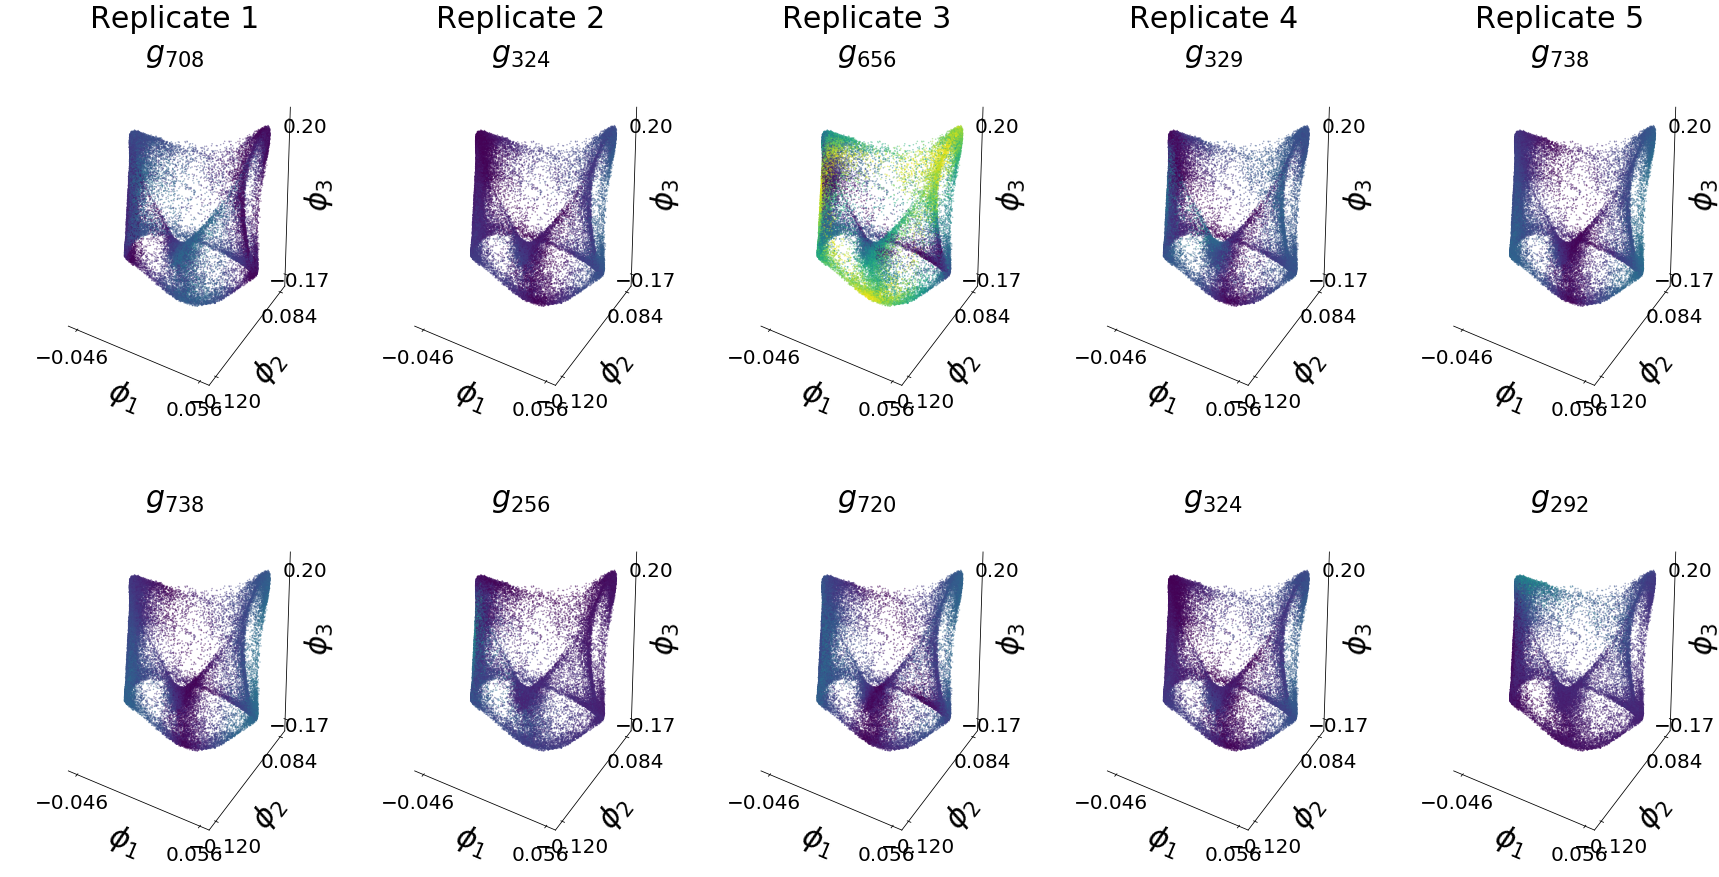

In [82]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,5, figsize = (30,15))

for r in range(5):
    for o in range(2):
        axs[o,r].set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(5):
    for o in range(2):
        ax = fig.add_subplot(2,5, o*5 + r + 1, projection='3d')
        #fig = plt.figure(figsize=(15,10))
        #ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.scatter(x, y, z, c = g_mf_inc[r,o], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
        ax.set_xlabel(r'$\phi_1$', fontsize = 30)
        ax.set_ylabel(r'$\phi_2$', fontsize = 30)
        ax.set_zlabel(r'$\phi_3$', fontsize = 30)
        
        if o ==0:
            ax.set_title('Replicate ' + str(r+1) + '\n' + r'$g_{{{}}}$'.format(incoherent_indices[r][sel[r][0]]), fontsize = 30)
        if o == 1:
            ax.set_title(r'$g_{{{}}}$'.format(incoherent_indices[r][sel[r][1]]), fontsize = 30)
        #ax.set_axis_off()
        xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
        xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
        ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
        ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
        zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
        zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
        ax.set_xticks([xmin, xmax])
        ax.set_yticks([ymin, ymax])
        ax.set_zticks([zmin, zmax])
        ax.tick_params(labelsize=20)

        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_full_sup_mflasso')

In [47]:
include = np.asarray([74,176])

In [225]:
# incoherent_indices = {}
# nreps = 1
# for r in range(nreps):
#     incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, .7, include)
#     replicates[r].dg_M_ds = replicates[r].dg_M[:,:,incoherent_indices[r]]
#     p = np.asarray(incoherent_indices[r], dtype = int).shape[0]
#     lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
#     #results[r] = Replicate()
#     #results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


In [226]:
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/ethanol_122620_pallrep5n100results.pkl' ,
         'rb') as loader:
     results = pickle.load(loader)
        
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/ethanol_122620_pallrep5n100replicates_small.pkl' ,
         'rb') as loader:
     replicates = pickle.load(loader)


In [227]:
xs = np.swapaxes(replicates[0].dg_M[:,:,np.asarray([74,176,722,713])],1,2)

In [228]:
cosine_similarities = np.zeros((100,4,4))
for i in range(100):
    for j1 in range(4):
        for j2 in range(4):
            cosine_similarities[i,j1,j2] = cosine_similarity(xs[i,j1],xs[i,j2])

In [236]:
rds = rearrange(xs[:,:,:], 'n p d -> (n d) p')

In [240]:
cosine_similarities_real = np.zeros((4,4))
for j1 in range(4):
    for j2 in range(4):
        cosine_similarities_real[j1,j2] = cosine_similarity(rds[:,j1],rds[:,j2])

Text(0.5, 1.0, 'Unregularized penalties')

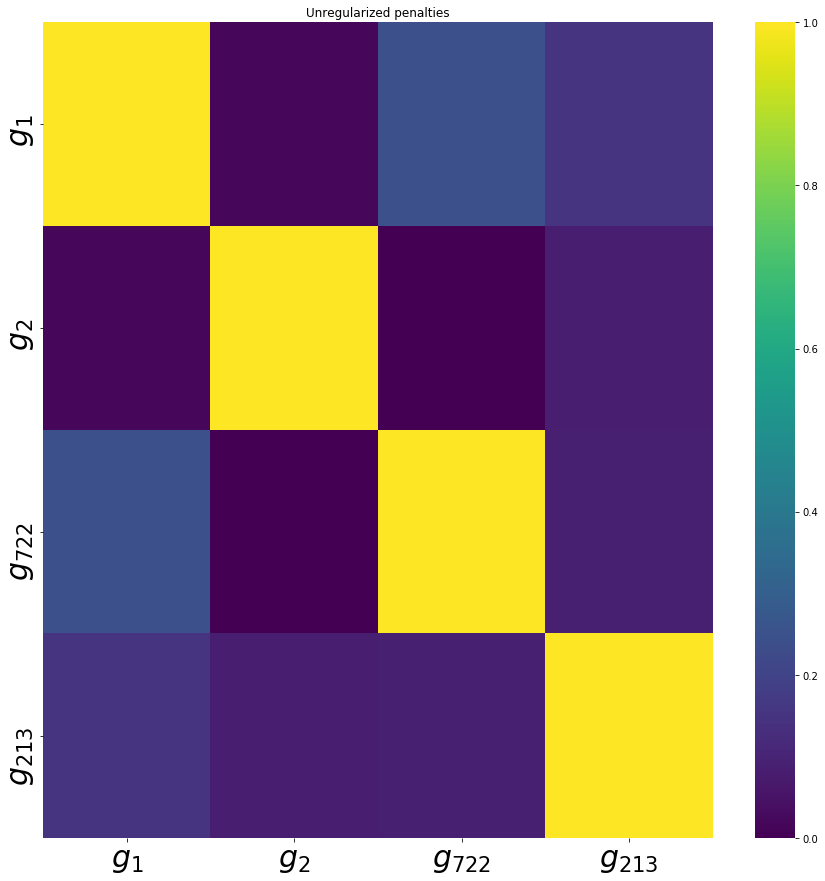

In [315]:
fig , ax = plt.subplots(1,1,figsize = (15,15))
sns.heatmap(np.abs(cosine_similarities_real), vmin = 0., vmax  = 1., cmap = 'viridis')
ax.set_xticklabels(functions, fontsize = 30)
ax.set_yticklabels(functions, fontsize = 30)
ax.set_title('Unregularized penalties')

In [ ]:
#cosine_similarity(xs[:,j1],xs[:,j2])

In [221]:
#np.mean(np.abs(cosine_similarities), axis = 0)
#np.mean(cosine_similarities**2, axis = 0)
#np.sqrt(np.mean(cosine_similarities**2, axis = 0))

\begin{eqnarray*}
&\frac{|x_1^T x_2|}{\|x_1\|\|x_2\|} \\
&= \frac{|[x_{11} x_{12}]^T [x_{21} x_{22}]|}{\|[x_{11} x_{12}]\|\|[x_{21} x_{22}]\|} \\
&= \frac{|x_{11}^T x_{21} +  x_{12}^T  x_{22}|}{\|[x_{11} x_{12}]\|\|[x_{21} x_{22}]\|} 
\end{eqnarray*}



In [229]:
np.mean(cosine_similarities, axis = 0)

array([[ 1.        , -0.00701058, -0.26184451, -0.14062304],
       [-0.00701058,  1.        ,  0.01528993, -0.05171099],
       [-0.26184451,  0.01528993,  1.        , -0.16768811],
       [-0.14062304, -0.05171099, -0.16768811,  1.        ]])

In [ ]:
#def get_cosines():

In [242]:
#get_cosines(np.swapaxes(replicates[0].dg_M[:,:,np.asarray([74,176,708,738])],1,2))

In [243]:
#trueandsel = [74,176,708,738]
trueandsel = [74,176,722,213]
np.linalg.norm(replicates[0].dg_M[:,:,np.asarray(trueandsel)], axis = tuple([0,1]))

array([0.48741654, 0.64175502, 0.74857015, 0.56914192])

In [244]:
norms = np.linalg.norm(replicates[0].dg_M[:,:,np.asarray(trueandsel)], axis = 1)

In [245]:
r = 0
np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M[:,:,np.asarray(trueandsel)]), axis = tuple([0,2]))
#np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M[:,:,:] , replicates[r].dg_M[:,:,[74,176,708,738]]))

array([0.07012356, 0.07132879, 0.10891507, 0.09581521])

In [246]:
r = 0
ptnorm = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M[:,:,np.asarray(trueandsel)]), axis = tuple([2]))
#np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M[:,:,:] , replicates[r].dg_M[:,:,[74,176,708,738]]))

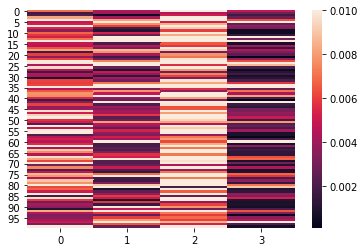

In [250]:
sns.heatmap(ptnorm, vmax= .01)

$\|x^Ty\|_{\infty, 2}$

$(x^T x)^{-1} x^t y$

In [251]:
np.median(ptnorm, axis = 0)

array([0.00564958, 0.00421398, 0.00850018, 0.0028232 ])

In [253]:
np.linalg.norm(norms, axis = 0)

array([0.48741654, 0.64175502, 0.74857015, 0.56914192])

In [296]:
functions = np.asarray([r'$g_1$', r'$g_2$', r'$g_{722}$', r'$g_{213}$'])

Text(0.5, 1.0, 'Norms')

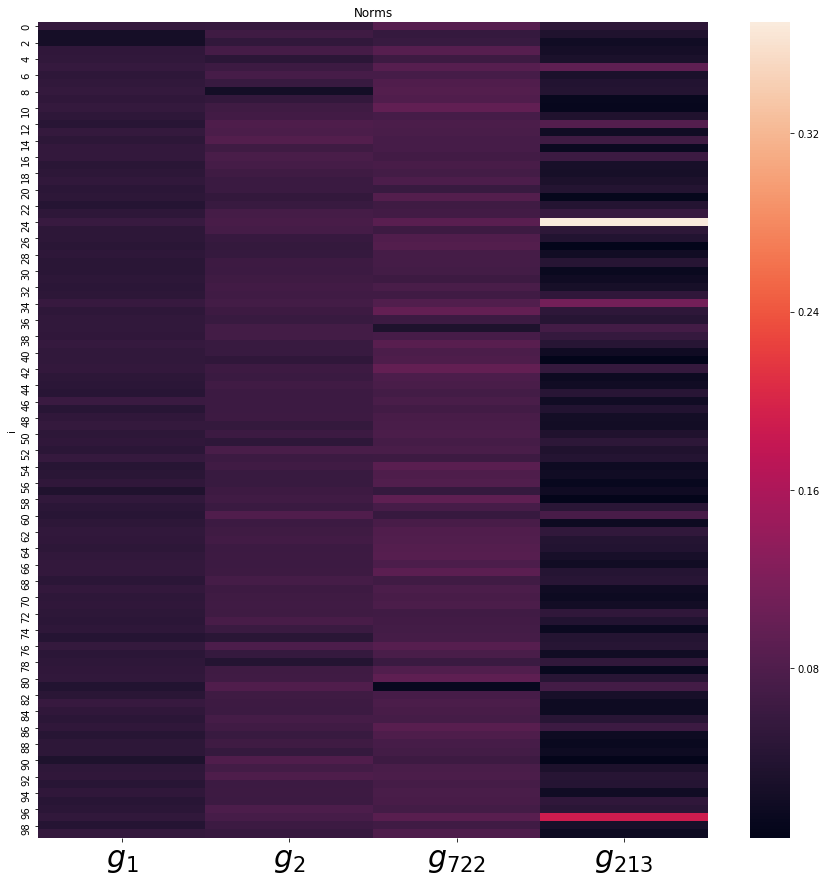

In [306]:
fig , ax = plt.subplots(1,1,figsize = (15,15))
sns.heatmap(norms, ax = ax)
ax.set_xticklabels(functions, fontsize = 30)
ax.set_ylabel('i')
ax.set_title('Norms')

In [259]:
dnoise = 2
supports_brute = {}
#for r in range(nreps):
r = 0
dg_M = replicates[r].dg_M[:,:,np.asarray(trueandsel)]
possebs= np.asarray(list(range(4)))#almost_sel[r]
p = len(possebs)
parameterizations_possible = np.asarray(list(combinations(range(p), dnoise)))
nparameterizations_possible = parameterizations_possible.shape[0]
penalties = np.zeros((nreps, nparameterizations_possible))
#ols_norm = np.zeros((nreps, p, p))
#subset
brute_coeffs = np.zeros((nsel, nparameterizations_possible, 2, 3))
orthogonality = np.zeros((nsel, nparameterizations_possible))
for i in range(nsel):
    for j in range(nparameterizations_possible):
        brute_coeffs[i, j] = np.linalg.lstsq(np.swapaxes(dg_M[i, :,possebs[parameterizations_possible[j]]],0,1), replicates[r].df_M[i])[0]
        # orthogonality[i,j] = get_penalty(brute_coeffs[i,j])
for j in range(nparameterizations_possible):
    penalties[r, j] = experiment.compute_penalty2(np.expand_dims(brute_coeffs[:, j], 0))
print('here')
sbr = parameterizations_possible[penalties[r, :].argmin()]
supports_brute[r] = possebs[sbr]

here


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [262]:
p

4

In [277]:
brutelosses = np.zeros((p,p))
for i in range(parameterizations_possible.shape[0]):
    brutelosses[parameterizations_possible[i,0], parameterizations_possible[i,1]]  = penalties[0][i]
    brutelosses[parameterizations_possible[i,1], parameterizations_possible[i,0]]  = penalties[0][i]

In [293]:
bls = pd.DataFrame(brutelosses, index=)

Text(0.5, 1.0, 'Unregularized penalties')

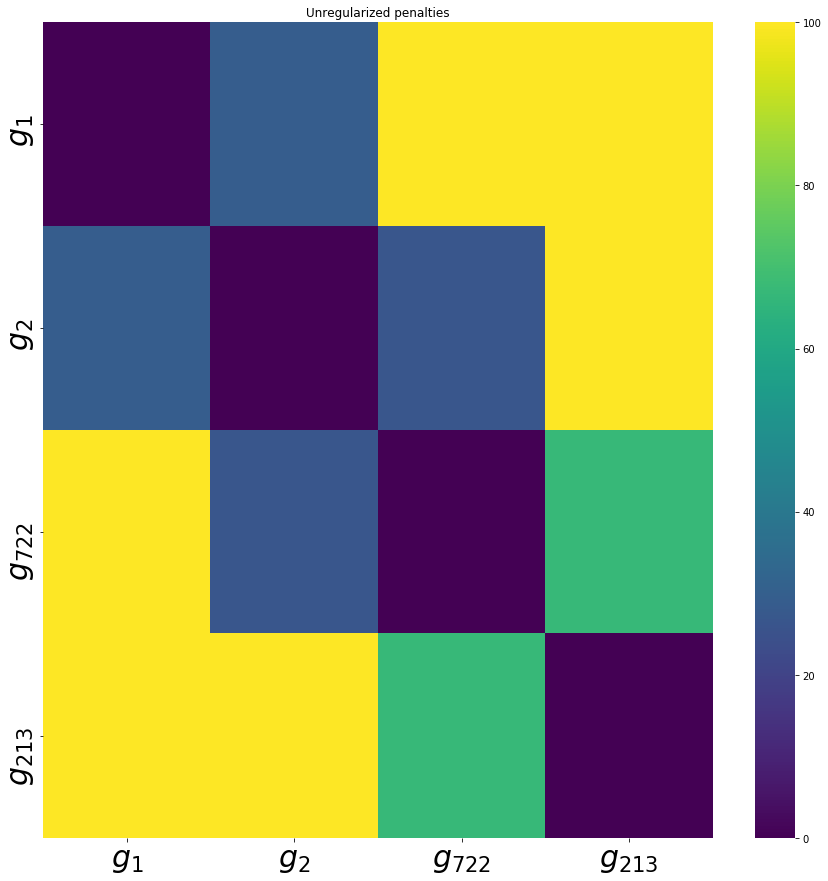

In [309]:
fig , ax = plt.subplots(1,1,figsize = (15,15))
sns.heatmap(brutelosses, vmin = 0., vmax  = 100., cmap = 'viridis')
ax.set_xticklabels(functions, fontsize = 30)
ax.set_yticklabels(functions, fontsize = 30)
ax.set_title('Unregularized penalties')


Text(0.5, 0.92, '$g_{213}$')

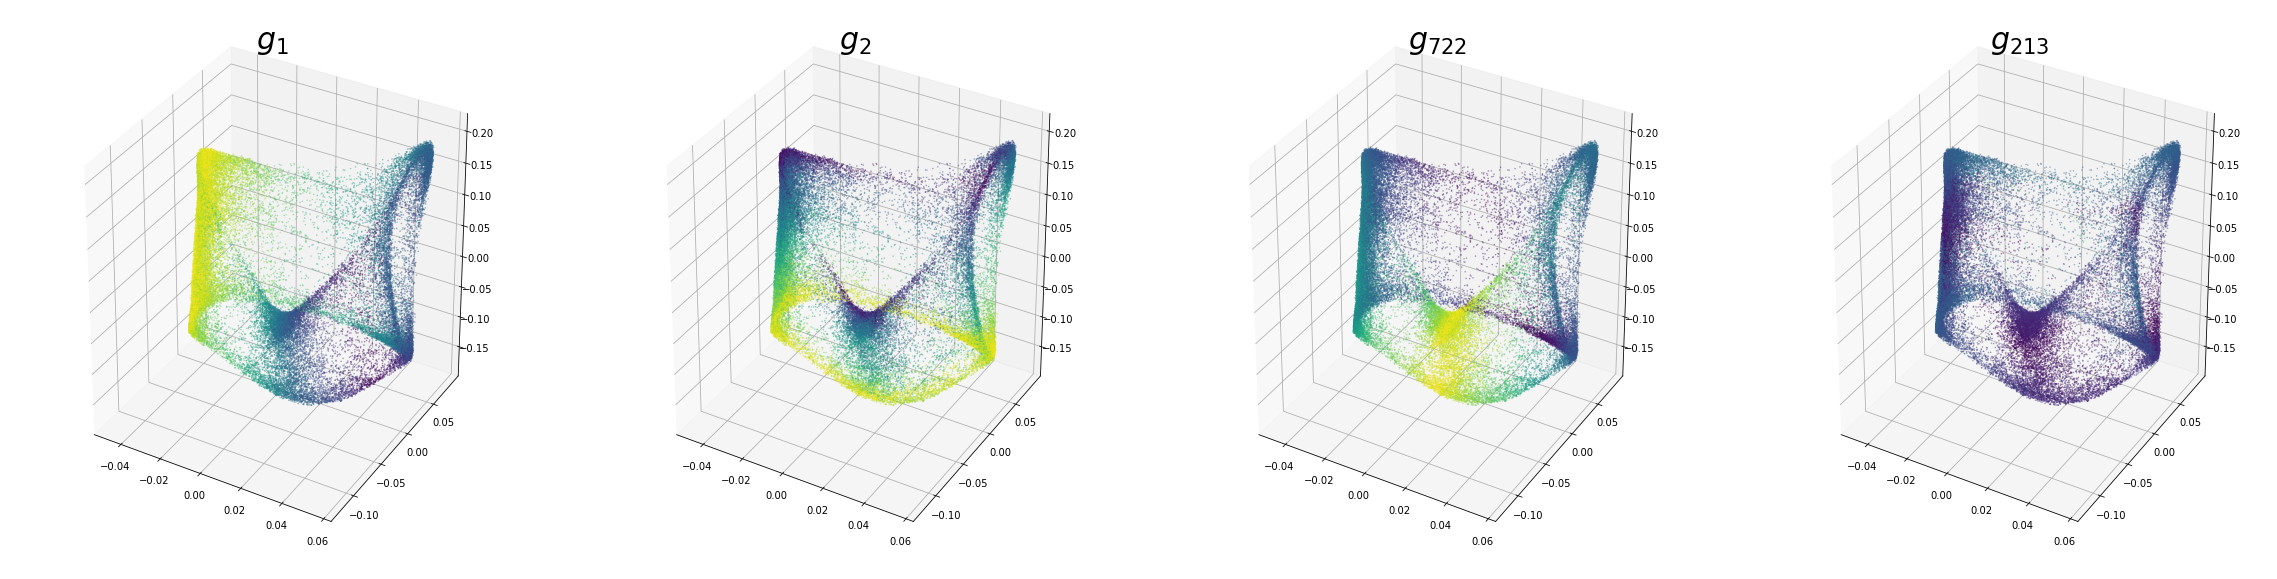

In [324]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,4, figsize = (40,10))

for r in range(1):
    for o in range(4):
        axs[o].set_axis_off()
        
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,4, 1, projection='3d')
#fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c = g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_title(r'$g_{1}$', fontsize = 30)

ax = fig.add_subplot(1,4, 2, projection='3d')
#fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c = g2, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_title(r'$g_{2}$', fontsize = 30)

ax = fig.add_subplot(1,4, 3, projection='3d')
#fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c = g_mf_inc[0,0], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_title(r'$g_{722}$', fontsize = 30)

ax = fig.add_subplot(1,4, 4, projection='3d')
#fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c = g_mf_inc[0,1], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_title(r'$g_{213}$', fontsize = 30)
        #ax.set_axis_off()


#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_full_sup_mflasso')

In [321]:
g_mf_inc.shape

(5, 2, 50000)

In [289]:
brutelosses

array([[   0.        ,   29.08217602,  187.76435367,  470.3089458 ],
       [  29.08217602,    0.        ,   26.88167225, 1099.24273767],
       [ 187.76435367,   26.88167225,    0.        ,   66.93866312],
       [ 470.3089458 , 1099.24273767,   66.93866312,    0.        ]])

In [36]:
brute_coeffs.shape

(100, 6, 2, 3)

In [27]:
include = np.asarray([74,176])

In [29]:
dg_M = replicates[0].dg_M

In [43]:
incoherent_indices = include
thresh = .8
#dg_M_down = 
keepers = np.asarray(list(range(dg_M.shape[2])))
coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, include)
cos_mean = coses.mean(axis = 0).max(axis = 0)
keepers = np.where(cos_mean < thresh)[0]

In [25]:
# def get_incoherent_dictionary(dg_M, thresh):
    
#     incoherent_indices = []

#     #dg_M_down = 
#     keepers = np.asarray(list(range(dg_M.shape[2])))
#     for i in range(100):
        
#         id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
#         ind_add = keepers[id_add]
#         incoherent_indices = np.append(incoherent_indices, ind_add)
        
#         #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
#         coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]
#         #keepers = keepers[np.where(np.max(np.abs(coses), axis = 0) < thresh)[0]]
#         keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
#         print(keepers)
#         if len(keepers) == 0:
#             break
            
#     return(np.asarray(incoherent_indices, dtype = int))

In [66]:
def get_incoherent_dictionary(dg_M, thresh):
    
    incoherent_indices = []

    #dg_M_down = 
    keepers = np.asarray(list(range(dg_M.shape[2])))
    for i in range(100):
        
        id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        ind_add = keepers[id_add]
        incoherent_indices = np.append(incoherent_indices, ind_add)
        
        #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]
        #keepers = keepers[np.where(np.max(np.abs(coses), axis = 0) < thresh)[0]]
        keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        print(keepers)
        if len(keepers) == 0:
            break
            
    return(np.asarray(incoherent_indices, dtype = int))

In [150]:
thresh = .9

In [151]:
get_incoherent_dictionary(replicates[0].dg_M, thresh)

[175 212 234 238 449 568]
[]


array([722, 568])

(array([  1.,   0.,   0.,   2.,   1.,   3.,  13.,  18.,  21., 697.]),
 array([0.77968913, 0.80172022, 0.8237513 , 0.84578239, 0.86781348,
        0.88984456, 0.91187565, 0.93390674, 0.95593783, 0.97796891,
        1.        ]),
 <a list of 10 Patch objects>)

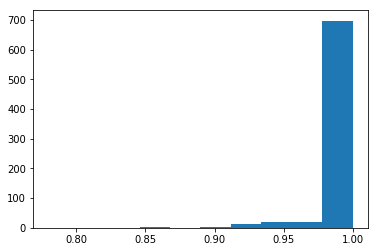

In [160]:
plt.hist(coses.max(axis = 0))

In [170]:
coses.max(axis = 0).shape

(756,)

In [173]:
def plot_loss(meanloss):
    fig = plt.figure(figsize=(30,25))
    ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=19)
    ax2 = plt.subplot2grid((20,20), (19,0), colspan=19, rowspan=1)
    #ax3 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)

    #mask = np.zeros_like(meanloss)
    #mask[np.tril_indices_from(mask)] = True

    sns.heatmap(meanloss, ax = ax1, annot=True, cmap="YlGnBu",linecolor='b', cbar = False)
    #ax1.xaxis.tick_top()
    #ax1.set_xticklabels(meanloss.columns,rotation=40)

    sns.heatmap((pd.DataFrame(meanloss.max(axis=0))).transpose(), ax=ax2,  annot=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)
    #sns.heatmap(pd.DataFrame(meanloss.mean(axis=1)), ax=ax3,  annot=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)

In [ ]:
plot_loss(np.abs(coses))

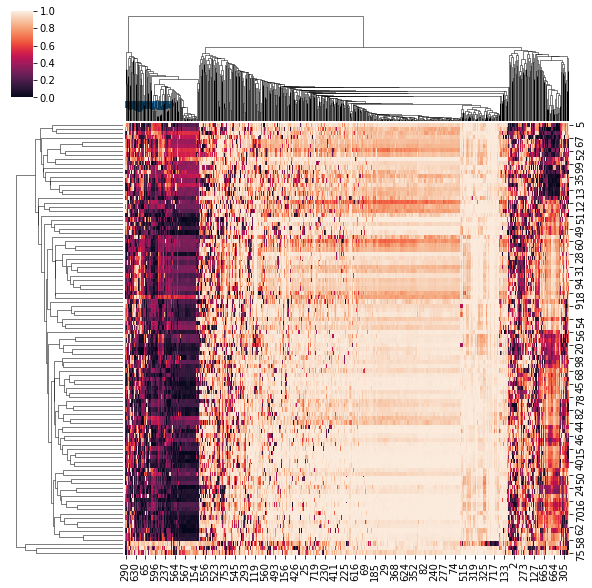

In [169]:
ax = sns.clustermap(np.abs(coses))
#ax.ax_col_dendrogram.set_visible(False)
ax.ax_col_dendrogram.scatter(list(range(756)),coses.max(axis = 0))

In [16]:
thresh = .8

In [46]:
    incoherent_indices = []

    #dg_M_down = 
    keepers = np.asarray(list(range(dg_M.shape[2])))
    for i in range(80):
        print(len(keepers))
        id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        ind_add = keepers[id_add]
        incoherent_indices = np.append(incoherent_indices, ind_add)
        
        #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        #print(keepers)
        coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        #print(keepers)
        if len(keepers) == 0:
            break
            


756
299
178
141
135
126
125
120
118
117
112
110
106
103
102
99
95
94
92
91
89
88
85
84
83
82
81
80
79
78
77
75
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
56
55
51
48
47
45
42
40
39
37
34
32
30
28
25
22
20
19
17
16
14
11
8
7
6
5
4
3
2
1


In [63]:
r = 0 
replicates[r].dg_M = replicates[r].dg_M[:,:,np.asarray(incoherent_indices, dtype = int)]

In [64]:
replicates[0].dg_M.shape

(100, 2, 77)

In [65]:
#selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
p = replicates[0].dg_M.shape[2]
lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100

In [209]:
from pathos.multiprocessing import ProcessingPool as Pool
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel


In [67]:
results = {}
for r in range(1):
    
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)
                    #batch_stream(replicates))



initializing lambda search
0
lr 100
lr 50.0
lr 25.0
lr 12.5
1
lr 12.5
2
lr 12.5
lr 6.25
3
lr 6.25
4
lr 6.25
5
lr 6.25
6
lr 6.25
7
lr 6.25
8
lr 6.25
9
lr 6.25
10
lr 6.25
11
lr 6.25
12
lr 6.25
13
lr 6.25
14
lr 6.25
15
lr 6.25
16
lr 6.25
17
lr 6.25
18
lr 6.25
19
lr 6.25
20
lr 6.25
21
lr 6.25
22
lr 6.25
23
lr 6.25
24
lr 6.25
25
lr 6.25
26
lr 6.25
27
lr 6.25
28
lr 6.25
29
lr 6.25
30
lr 6.25
31
lr 6.25
32
lr 6.25
33
lr 6.25
34
lr 6.25
35
lr 6.25
36
lr 6.25
37
lr 6.25
38
lr 6.25
39
lr 6.25
40
lr 6.25
41
lr 6.25
42
lr 6.25
43
lr 6.25
44
lr 6.25
45
lr 6.25
46
lr 6.25
47
lr 6.25
48
lr 6.25
49
lr 6.25
50
lr 6.25
51
lr 6.25
52
lr 6.25
53
lr 6.25
54
lr 6.25
55
lr 6.25
56
lr 6.25
57
lr 6.25
58
lr 6.25
59
lr 6.25
60
lr 6.25
61
lr 6.25
62
lr 6.25
63
lr 6.25
64
lr 6.25
65
lr 6.25
66
lr 6.25
67
lr 6.25
68
lr 6.25
69
lr 6.25
70
lr 6.25
71
lr 6.25
72
lr 6.25
73
lr 6.25
74
lr 6.25
75
lr 6.25
76
lr 6.25
77
lr 6.25
78
lr 6.25
79
lr 6.25
80
lr 6.25
81
lr 6.25
82
lr 6.25
83
lr 6.25
84
lr 6.25
85
lr 6.25
86
lr 

204
lr 12.5
205
lr 12.5
206
lr 12.5
207
lr 12.5
208
lr 12.5
209
lr 12.5
210
lr 12.5
211
lr 12.5
212
lr 12.5
213
lr 12.5
214
lr 12.5
215
lr 12.5
216
lr 12.5
217
lr 12.5
218
lr 12.5
219
lr 12.5
220
lr 12.5
221
lr 12.5
222
lr 12.5
223
lr 12.5
224
lr 12.5
225
lr 12.5
226
lr 12.5
227
lr 12.5
228
lr 12.5
229
lr 12.5
230
lr 12.5
231
lr 12.5
232
lr 12.5
233
lr 12.5
234
lr 12.5
235
lr 12.5
236
lr 12.5
237
lr 12.5
238
lr 12.5
239
lr 12.5
240
lr 12.5
241
lr 12.5
242
lr 12.5
243
lr 12.5
244
lr 12.5
245
lr 12.5
246
lr 12.5
247
lr 12.5
248
lr 12.5
249
lr 12.5
250
lr 12.5
251
lr 12.5
252
lr 12.5
253
lr 12.5
254
lr 12.5
255
lr 12.5
256
lr 12.5
257
lr 12.5
258
lr 12.5
259
lr 12.5
260
lr 12.5
261
lr 12.5
262
lr 12.5
263
lr 12.5
264
lr 12.5
265
lr 12.5
266
lr 12.5
267
lr 12.5
268
lr 12.5
269
lr 12.5
270
lr 12.5
271
lr 12.5
272
lr 12.5
273
lr 12.5
274
lr 12.5
275
lr 12.5
276
lr 12.5
277
lr 12.5
278
lr 12.5
279
lr 12.5
280
lr 12.5
281
lr 12.5
282
lr 12.5
283
lr 12.5
284
lr 12.5
285
lr 12.5
286
lr 12.5
287


In [70]:
nreps = 1
for r in range(nreps):
    #r = 0 
    cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis

#nreps = 5
sel_l = np.zeros(nreps, dtype = int)
for r in range(nreps):
    for l in range(replicates[r].cs_reorder.shape[0]):
        zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
        if len(zeros) == 2:
            sel_l[r] = l
            #print(np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[2] !=0.))

almost_sel = {}
sel = {}
for r in range(nreps):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    almost_sel[r] = zeros

In [74]:
#pretty slow
#g_mf = np.zeros((5,2,50000))
#for r in range(5):
    for o in range(2):
        print(a4[incoherent_indices[r][sel[r]][o]])

IndexError: invalid index to scalar variable.

In [75]:
incoherent_indices

array([ 74, 176, 662, 708, 698, 738, 330, 499, 290, 268, 125, 304, 254,
       266, 302, 256, 538, 257, 545, 683, 697, 681, 273, 679, 288, 533,
       306, 695, 699, 264, 307, 310, 311, 755, 754, 173, 561, 563, 549,
       647, 556, 550, 562, 555, 316, 312, 340, 315, 112,  93, 339, 337,
        96,   5, 336,  10,  99,   9,  90, 109,  41,   2, 127,   1, 131,
       113,  37, 524, 523, 130, 313, 314,  98, 338,  38, 317, 128])

In [92]:
sel

{0: array([0, 5]),
 1: array([0, 7]),
 2: array([0, 2]),
 3: array([0, 2]),
 4: array([0, 9])}

In [7]:
atoms4 , p = get_all_atoms_4(9)

In [8]:
atoms4

array([[0, 1, 2, 3],
       [1, 0, 2, 3],
       [3, 1, 0, 2],
       ...,
       [7, 6, 8, 5],
       [5, 8, 7, 6],
       [6, 5, 8, 7]])

In [93]:
#pretty slow
g_mf = np.zeros((5,2,50000))
for r in range(5):
    for o in range(2):
        print(o)
        g_mf[r,o] =  experiment.get_g_full_sub(experiment.M.data, atoms4[incoherent_indices[r][sel[r]][o]])

0
1
0
1
0
1
0
1
0
1


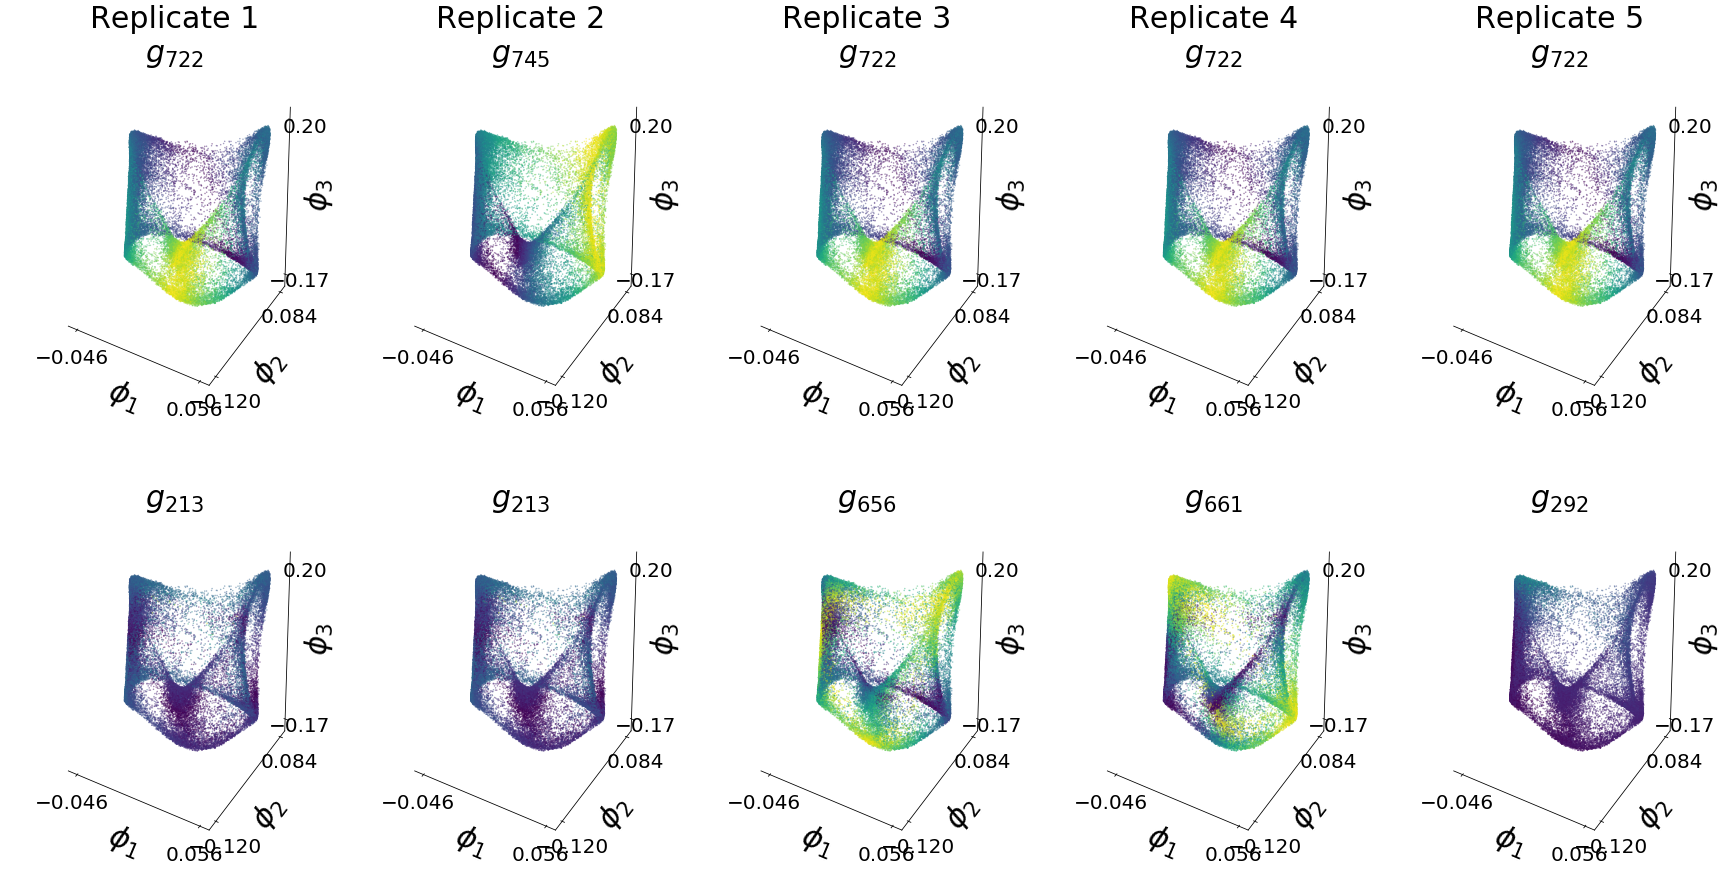

In [95]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,5, figsize = (30,15))

for r in range(5):
    for o in range(2):
        axs[o,r].set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(5):
    for o in range(2):
        ax = fig.add_subplot(2,5, o*5 + r + 1, projection='3d')
        #fig = plt.figure(figsize=(15,10))
        #ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.scatter(x, y, z, c = g_mf[r,o], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
        ax.set_xlabel(r'$\phi_1$', fontsize = 30)
        ax.set_ylabel(r'$\phi_2$', fontsize = 30)
        ax.set_zlabel(r'$\phi_3$', fontsize = 30)
        
        if o ==0:
            ax.set_title('Replicate ' + str(r+1) + '\n' + r'$g_{{{}}}$'.format(incoherent_indices[r][sel[r][0]]), fontsize = 30)
        if o == 1:
            ax.set_title(r'$g_{{{}}}$'.format(incoherent_indices[r][sel[r][1]]), fontsize = 30)
        #ax.set_axis_off()
        xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
        xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
        ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
        ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
        zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
        zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
        ax.set_xticks([xmin, xmax])
        ax.set_yticks([ymin, ymax])
        ax.set_zticks([zmin, zmax])
        ax.tick_params(labelsize=20)

        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)    
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_full_sup_mflasso')

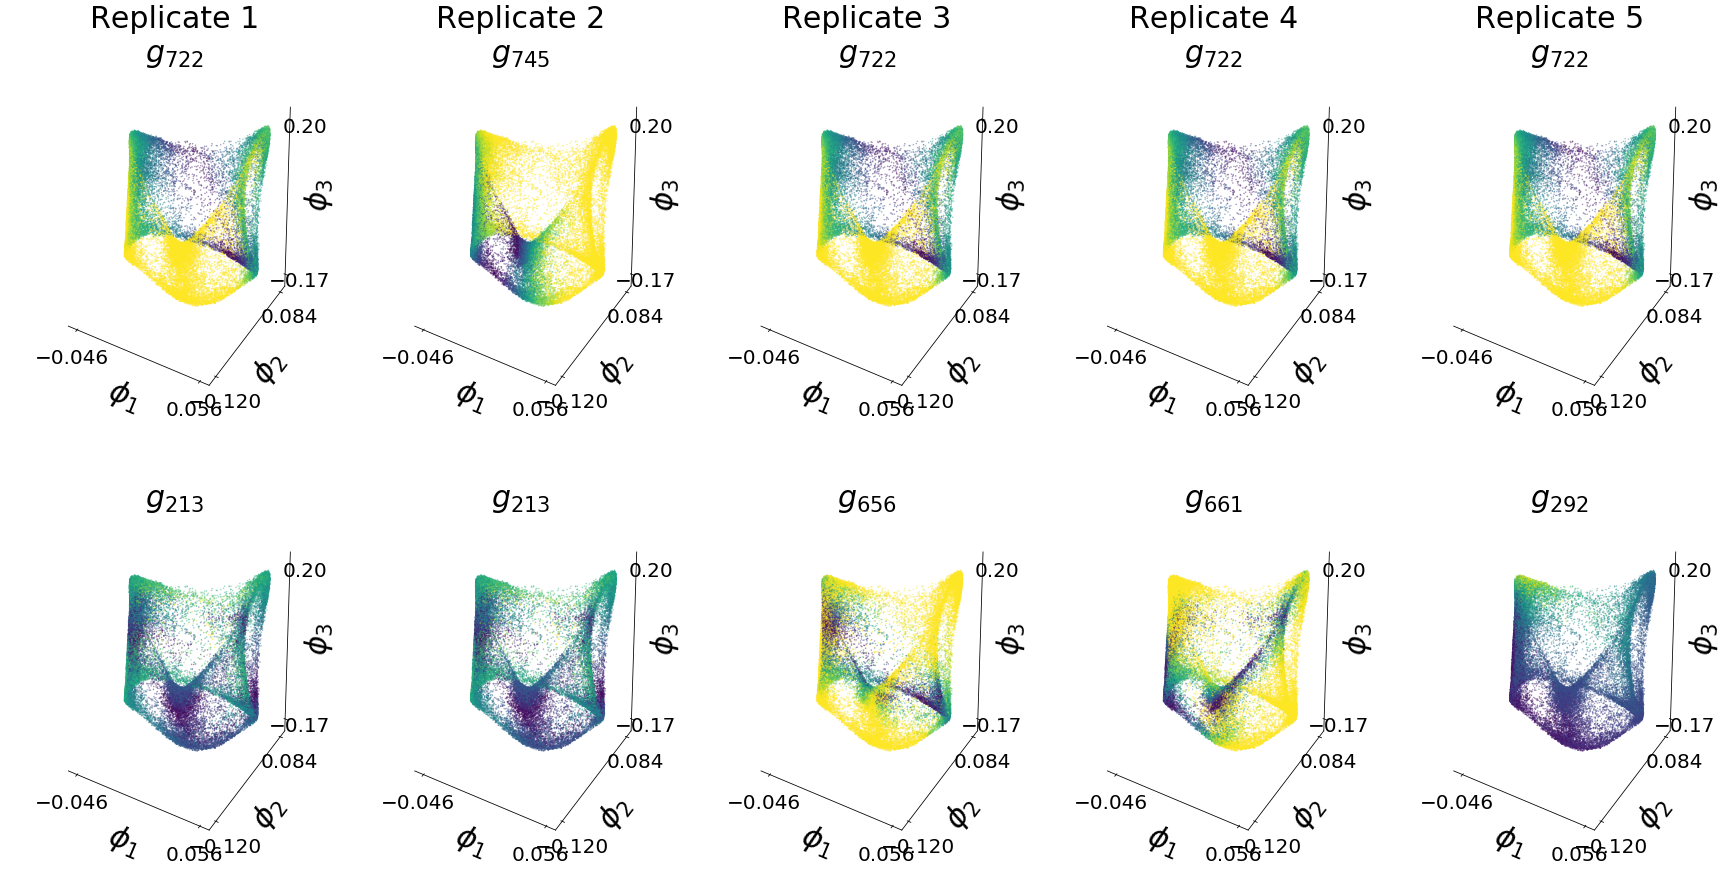

In [97]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,5, figsize = (30,15))

for r in range(5):
    for o in range(2):
        axs[o,r].set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(5):
    for o in range(2):
        ax = fig.add_subplot(2,5, o*5 + r + 1, projection='3d')
        #fig = plt.figure(figsize=(15,10))
        #ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.scatter(x, y, z, c = g_mf[r,o], s=s, alpha=alpha, marker='.',vmin=0.,vmax=np.pi/2)
        ax.set_xlabel(r'$\phi_1$', fontsize = 30)
        ax.set_ylabel(r'$\phi_2$', fontsize = 30)
        ax.set_zlabel(r'$\phi_3$', fontsize = 30)
        
        if o ==0:
            ax.set_title('Replicate ' + str(r+1) + '\n' + r'$g_{{{}}}$'.format(incoherent_indices[r][sel[r][0]]), fontsize = 30)
        if o == 1:
            ax.set_title(r'$g_{{{}}}$'.format(incoherent_indices[r][sel[r][1]]), fontsize = 30)
        #ax.set_axis_off()
        xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
        xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
        ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
        ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
        zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
        zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
        ax.set_xticks([xmin, xmax])
        ax.set_yticks([ymin, ymax])
        ax.set_zticks([zmin, zmax])
        ax.tick_params(labelsize=20)

        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)    
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_full_sup_mflasso')

In [ ]:
g_mf[0,1].max()

In [116]:
for r in range(5):
    print(len(incoherent_indices[r]))
    print(np.linalg.norm(replicates[r].dg_M[:,:,213]),np.linalg.norm(replicates[r].dg_M[:,:,656]))

78
0.5691419244371763 0.6169312905341731
75
0.5855208022107412 0.6778907623842974
73
0.560804233729128 0.6778018804360784
70
0.5801414402516942 0.6692375974083664
74
0.5070514633651678 0.5395547204245692


0.6169312905341731

In [100]:
g_mf[1,1].max()

3.1411554521037135

In [90]:
atoms4

array([[6, 1, 0, 4],
       [4, 0, 2, 8],
       [7, 6, 5, 1],
       [3, 0, 2, 4]])

In [88]:
for r in range(nreps):
    print(incoherent_indices[r][sel[r]])

[722 213]
[745 213]
[722 656]
[722 661]
[722 292]


In [83]:
incoherent_indices[r]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73])

In [82]:
incoherent_indices[r] = get_incoherent_dictionary(replicates[r].dg_M, thresh)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73]
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73]
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 

In [101]:
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/ethanol_122620_pallrep5n100results.pkl' ,
         'rb') as loader:
     results = pickle.load(loader)
        
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/ethanol_122620_pallrep5n100replicates_small.pkl' ,
         'rb') as loader:
     replicates = pickle.load(loader)


In [85]:
incoherent_indices = {}
nreps = 5
for r in range(nreps):
    incoherent_indices[r] = get_incoherent_dictionary(replicates[r].dg_M, thresh)
    replicates[r].dg_M = replicates[r].dg_M[:,:,incoherent_indices[r]]
    p = np.asarray(incoherent_indices[r], dtype = int).shape[0]
    lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


[  0   1   2   3   4   5   6   7   8   9  10  11  30  31  32  33  34  35
  36  37  38  39  40  41  60  61  62  63  64  65  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 108 109 110 111 112
 113 120 126 127 128 129 130 131 150 151 152 153 154 155 161 173 174 175
 176 177 178 179 192 193 194 195 196 197 204 205 206 207 208 209 210 211
 212 213 214 215 234 235 236 237 238 239 252 253 254 255 256 257 264 265
 266 267 268 269 270 271 272 273 274 275 288 289 290 291 292 293 300 301
 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 324 330
 336 337 338 339 340 341 360 361 362 363 364 365 384 385 386 387 388 389
 402 403 404 405 406 407 414 415 416 417 418 419 420 421 422 423 424 425
 444 445 446 447 448 449 475 481 517 522 523 524 525 526 527 532 533 534
 535 538 539 540 541 544 545 549 550 551 555 556 561 562 563 564 565 566
 567 568 569 582 583 584 585 586 587 594 595 596 597 598 599 600 601 602
 603 604 605 618 619 620 621 622 623 630 631 632 63

[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 161 173 264 270 271 273 274 275 288 306 307 310
 311 312 313 314 315 316 317 336 337 338 339 340 341 522 523 524 525 526
 527 533 549 550 551 555 556 561 562 563 647 681 693 695 697 699 701 754
 755]
[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 161 173 264 271 273 274 275 288 306 307 310 311
 312 313 314 315 316 317 336 337 338 339 340 341 522 523 524 525 526 527
 533 549 550 551 555 556 561 562 563 647 681 693 695 699 701 754 755]
[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 161 173 264 271 273 274 275 288 306 307 310 311
 312 313 314 315 316 317 336 337 338 339 340 341

[  0   1   2   3   4   5   6   7   8   9  10  36  37  38  39  40  41  90
  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113 126
 127 128 129 130 131 313 314 315 317 336 337 338 339 341 522 523 524 525
 526 527]
[  0   1   2   3   4   5   6   7   8   9  10  36  37  38  39  40  41  90
  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113 126
 127 128 129 130 131 313 314 317 336 337 338 339 341 522 523 524 525 526
 527]
[  0   1   2   3   4   5   6   7   8   9  10  36  37  38  39  40  41  90
  91  92  93  94  96  97  98  99 100 101 109 110 113 126 127 128 129 130
 131 313 314 317 336 337 338 339 341 522 523 524 525 526 527]
[  0   1   2   3   4   5   6   7   8   9  10  36  37  38  39  40  41  90
  91  96  97  98  99 100 101 109 110 113 126 127 128 129 130 131 313 314
 317 336 337 338 339 341 522 523 524 525 526 527]
[  0   1   2   3   4   5   6   7   8   9  10  36  37  38  39  40  41  90
  91  96  97  98  99 100 101 109 110 113 126 127 128 129 130 131 313 

lr 6.25
426
lr 6.25
427
lr 6.25
428
lr 6.25
429
lr 6.25
430
lr 6.25
431
lr 6.25
432
lr 6.25
433
lr 6.25
434
lr 6.25
435
lr 6.25
436
lr 6.25
437
lr 6.25
438
lr 6.25
439
lr 6.25
440
lr 6.25
441
lr 6.25
442
lr 6.25
443
lr 6.25
444
lr 6.25
445
lr 6.25
446
lr 6.25
447
lr 6.25
448
lr 6.25
449
lr 6.25
450
lr 6.25
451
lr 6.25
452
lr 6.25
453
lr 6.25
454
lr 6.25
455
lr 6.25
456
lr 6.25
457
lr 6.25
458
lr 6.25
459
lr 6.25
460
lr 6.25
461
lr 6.25
462
lr 6.25
463
lr 6.25
464
lr 6.25
465
lr 6.25
466
lr 6.25
467
lr 6.25
468
lr 6.25
469
lr 6.25
470
lr 6.25
471
lr 6.25
472
lr 6.25
473
lr 6.25
474
lr 6.25
475
lr 6.25
476
lr 6.25
477
lr 6.25
478
lr 6.25
479
lr 6.25
480
lr 6.25
481
lr 6.25
482
lr 6.25
483
lr 6.25
484
lr 6.25
485
lr 6.25
486
lr 6.25
487
lr 6.25
488
lr 6.25
489
lr 6.25
490
lr 6.25
491
lr 6.25
492
lr 6.25
493
lr 6.25
494
lr 6.25
495
lr 6.25
496
lr 6.25
497
lr 6.25
498
lr 6.25
499
lr 6.25
0
lr 100
lr 50.0
lr 25.0
1
lr 25.0
lr 12.5
2
lr 12.5
3
lr 12.5
lr 6.25
4
lr 6.25
5
lr 6.25
6
lr 6.25
7
l

lr 6.25
122
lr 6.25
123
lr 6.25
124
lr 6.25
125
lr 6.25
126
lr 6.25
127
lr 6.25
128
lr 6.25
129
lr 6.25
130
lr 6.25
131
lr 6.25
132
lr 6.25
133
lr 6.25
134
lr 6.25
135
lr 6.25
136
lr 6.25
137
lr 6.25
138
lr 6.25
139
lr 6.25
140
lr 6.25
141
lr 6.25
142
lr 6.25
143
lr 6.25
144
lr 6.25
145
lr 6.25
146
lr 6.25
147
lr 6.25
148
lr 6.25
149
lr 6.25
150
lr 6.25
151
lr 6.25
152
lr 6.25
153
lr 6.25
154
lr 6.25
155
lr 6.25
156
lr 6.25
157
lr 6.25
158
lr 6.25
159
lr 6.25
160
lr 6.25
161
lr 6.25
162
lr 6.25
163
lr 6.25
164
lr 6.25
165
lr 6.25
166
lr 6.25
167
lr 6.25
168
lr 6.25
169
lr 6.25
170
lr 6.25
171
lr 6.25
172
lr 6.25
173
lr 6.25
174
lr 6.25
175
lr 6.25
176
lr 6.25
177
lr 6.25
178
lr 6.25
179
lr 6.25
180
lr 6.25
181
lr 6.25
182
lr 6.25
183
lr 6.25
184
lr 6.25
185
lr 6.25
186
lr 6.25
187
lr 6.25
188
lr 6.25
189
lr 6.25
190
lr 6.25
191
lr 6.25
192
lr 6.25
193
lr 6.25
194
lr 6.25
195
lr 6.25
196
lr 6.25
197
lr 6.25
198
lr 6.25
199
lr 6.25
200
lr 6.25
201
lr 6.25
202
lr 6.25
203
lr 6.25
204
lr 6

[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 137 138 143 173 252 254 264 265 267 269 270 271
 272 273 274 275 303 307 310 311 312 313 314 315 316 317 336 337 338 339
 340 341 522 523 524 525 526 527 531 545 549 550 551 555 556 557 561 562
 563 643 647 679 681 683 695 697 701 703 753 754 755]
[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 137 138 143 173 252 264 265 267 269 270 271 272
 273 274 275 303 307 310 311 312 313 314 315 316 317 336 337 338 339 340
 341 522 523 524 525 526 527 531 545 549 550 551 555 556 557 561 562 563
 643 647 679 681 683 695 697 701 703 753 754 755]
[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130

[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 312 313 314 315 316 317 336 337 338 339 340 341
 522 523 524 525 526 527 555 557 561 703]
[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 312 313 314 315 316 317 336 337 338 339 340 341
 522 523 524 525 526 527 555 557 703]
[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 312 313 314 315 316 317 336 337 338 339 340 341
 522 523 524 525 526 527 557 703]
[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 312 313 314 315 316 317 336 337 338 339 340 341
 522 523 5

300
lr 6.25
301
lr 6.25
302
lr 6.25
303
lr 6.25
304
lr 6.25
305
lr 6.25
306
lr 6.25
307
lr 6.25
308
lr 6.25
309
lr 6.25
310
lr 6.25
311
lr 6.25
312
lr 6.25
313
lr 6.25
314
lr 6.25
315
lr 6.25
316
lr 6.25
317
lr 6.25
318
lr 6.25
319
lr 6.25
320
lr 6.25
321
lr 6.25
322
lr 6.25
323
lr 6.25
324
lr 6.25
325
lr 6.25
326
lr 6.25
327
lr 6.25
328
lr 6.25
329
lr 6.25
330
lr 6.25
331
lr 6.25
332
lr 6.25
333
lr 6.25
334
lr 6.25
335
lr 6.25
336
lr 6.25
337
lr 6.25
338
lr 6.25
339
lr 6.25
340
lr 6.25
341
lr 6.25
342
lr 6.25
343
lr 6.25
344
lr 6.25
345
lr 6.25
346
lr 6.25
347
lr 6.25
348
lr 6.25
349
lr 6.25
350
lr 6.25
351
lr 6.25
352
lr 6.25
353
lr 6.25
354
lr 6.25
355
lr 6.25
356
lr 6.25
357
lr 6.25
358
lr 6.25
359
lr 6.25
360
lr 6.25
361
lr 6.25
362
lr 6.25
363
lr 6.25
364
lr 6.25
365
lr 6.25
366
lr 6.25
367
lr 6.25
368
lr 6.25
369
lr 6.25
370
lr 6.25
371
lr 6.25
372
lr 6.25
373
lr 6.25
374
lr 6.25
375
lr 6.25
376
lr 6.25
377
lr 6.25
378
lr 6.25
379
lr 6.25
380
lr 6.25
381
lr 6.25
382
lr 6.25
383


lr 100
lr 50.0
2
lr 50.0
3
lr 50.0
4
lr 50.0
5
lr 50.0
6
lr 50.0
7
lr 50.0
8
lr 50.0
9
lr 50.0
10
lr 50.0
11
lr 50.0
12
lr 50.0
13
lr 50.0
14
lr 50.0
15
lr 50.0
16
lr 50.0
17
lr 50.0
18
lr 50.0
19
lr 50.0
20
lr 50.0
21
lr 50.0
22
lr 50.0
23
lr 50.0
24
lr 50.0
25
lr 50.0
26
lr 50.0
27
lr 50.0
28
lr 50.0
29
lr 50.0
30
lr 50.0
31
lr 50.0
32
lr 50.0
33
lr 50.0
34
lr 50.0
35
lr 50.0
36
lr 50.0
37
lr 50.0
38
lr 50.0
39
lr 50.0
40
lr 50.0
41
lr 50.0
42
lr 50.0
43
lr 50.0
44
lr 50.0
45
lr 50.0
46
lr 50.0
47
lr 50.0
48
lr 50.0
49
lr 50.0
converged 0.08660254037844387
1 0.0649519052838329 probe
0
lr 100
lr 50.0
1
lr 50.0
2
lr 50.0
lr 25.0
3
lr 25.0
4
lr 25.0
5
lr 25.0
6
lr 25.0
7
lr 25.0
8
lr 25.0
9
lr 25.0
10
lr 25.0
11
lr 25.0
12
lr 25.0
13
lr 25.0
14
lr 25.0
15
lr 25.0
16
lr 25.0
17
lr 25.0
18
lr 25.0
19
lr 25.0
20
lr 25.0
21
lr 25.0
22
lr 25.0
23
lr 25.0
24
lr 25.0
25
lr 25.0
26
lr 25.0
27
lr 25.0
28
lr 25.0
29
lr 25.0
30
lr 25.0
31
lr 25.0
32
lr 25.0
33
lr 25.0
34
lr 25.0
35
lr 25.0
36
lr 2

[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 102 108 109 110 111 112
 113 114 126 127 128 129 130 131 142 143 149 161 173 252 253 255 256 257
 264 265 269 270 271 273 274 275 288 289 291 292 293 300 301 303 304 305
 306 307 309 310 311 312 313 314 315 316 317 324 336 338 339 340 475 481
 522 523 524 525 526 527 529 530 531 532 533 534 536 538 539 542 544 545
 549 550 551 555 556 557 561 562 563 678 681 683 695 701 751 753 754 755]
[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 102 108 109 110 111 112
 113 114 126 127 128 129 130 131 142 143 149 161 173 252 253 255 256 257
 264 265 269 270 271 273 274 275 288 289 291 292 293 300 301 303 304 305
 306 307 309 310 311 312 313 314 315 316 317 336 338 339 340 475 522 523
 524 525 526 527 529 530 531 532 533 536 539 542 544 545 549 550 551 555
 556 557 561 562 563 678 681 683 695 701 753 754 7

[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 161 173 312 313 314 315 316 317 336 338 339 340
 522 523 524 525 526 527 549 550 551 555 556 557 562 563]
[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 161 312 313 314 315 316 317 336 338 339 340 522
 523 524 525 526 527 549 550 551 555 556 557 562 563]
[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 312 313 314 315 316 317 336 338 339 340 522 523
 524 525 526 527 549 550 551 555 556 557 562 563]
[  0   1   2   3   4   5   6   7   8   9  10  11  36  37  38  39  40  41
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 126 127 128 129 130 131 312 313 31

lr 1.5625
169
lr 1.5625
170
lr 1.5625
171
lr 1.5625
172
lr 1.5625
173
lr 1.5625
174
lr 1.5625
175
lr 1.5625
176
lr 1.5625
177
lr 1.5625
178
lr 1.5625
179
lr 1.5625
180
lr 1.5625
181
lr 1.5625
182
lr 1.5625
183
lr 1.5625
184
lr 1.5625
185
lr 1.5625
186
lr 1.5625
187
lr 1.5625
188
lr 1.5625
189
lr 1.5625
190
lr 1.5625
191
lr 1.5625
192
lr 1.5625
193
lr 1.5625
194
lr 1.5625
195
lr 1.5625
196
lr 1.5625
197
lr 1.5625
198
lr 1.5625
199
lr 1.5625
200
lr 1.5625
201
lr 1.5625
202
lr 1.5625
203
lr 1.5625
204
lr 1.5625
205
lr 1.5625
206
lr 1.5625
207
lr 1.5625
208
lr 1.5625
209
lr 1.5625
210
lr 1.5625
211
lr 1.5625
212
lr 1.5625
213
lr 1.5625
214
lr 1.5625
215
lr 1.5625
216
lr 1.5625
217
lr 1.5625
218
lr 1.5625
219
lr 1.5625
220
lr 1.5625
221
lr 1.5625
222
lr 1.5625
223
lr 1.5625
224
lr 1.5625
225
lr 1.5625
226
lr 1.5625
227
lr 1.5625
228
lr 1.5625
229
lr 1.5625
230
lr 1.5625
231
lr 1.5625
232
lr 1.5625
233
lr 1.5625
234
lr 1.5625
235
lr 1.5625
236
lr 1.5625
237
lr 1.5625
238
lr 1.5625
239
lr 1.5

lr 1.5625
269
lr 1.5625
270
lr 1.5625
271
lr 1.5625
272
lr 1.5625
273
lr 1.5625
274
lr 1.5625
275
lr 1.5625
276
lr 1.5625
277
lr 1.5625
278
lr 1.5625
279
lr 1.5625
280
lr 1.5625
281
lr 1.5625
282
lr 1.5625
283
lr 1.5625
284
lr 1.5625
285
lr 1.5625
286
lr 1.5625
287
lr 1.5625
288
lr 1.5625
289
lr 1.5625
290
lr 1.5625
291
lr 1.5625
292
lr 1.5625
293
lr 1.5625
294
lr 1.5625
295
lr 1.5625
296
lr 1.5625
297
lr 1.5625
298
lr 1.5625
299
lr 1.5625
300
lr 1.5625
301
lr 1.5625
302
lr 1.5625
303
lr 1.5625
304
lr 1.5625
305
lr 1.5625
306
lr 1.5625
307
lr 1.5625
308
lr 1.5625
309
lr 1.5625
310
lr 1.5625
311
lr 1.5625
312
lr 1.5625
313
lr 1.5625
314
lr 1.5625
315
lr 1.5625
316
lr 1.5625
317
lr 1.5625
318
lr 1.5625
319
lr 1.5625
320
lr 1.5625
321
lr 1.5625
322
lr 1.5625
323
lr 1.5625
324
lr 1.5625
325
lr 1.5625
326
lr 1.5625
327
lr 1.5625
328
lr 1.5625
329
lr 1.5625
330
lr 1.5625
331
lr 1.5625
332
lr 1.5625
333
lr 1.5625
334
lr 1.5625
335
lr 1.5625
336
lr 1.5625
337
lr 1.5625
338
lr 1.5625
339
lr 1.5

[  0   1   2   3   4   5   6   7   9  10  11  36  37  38  39  40  41  90
  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113 120
 126 127 128 129 130 131 143 161 173 195 252 253 254 255 256 257 264 265
 266 267 268 269 270 271 272 273 274 275 288 289 290 291 292 293 300 301
 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 324 330
 336 338 339 340 341 402 403 404 405 406 407 414 415 416 417 418 419 420
 421 423 475 481 517 522 523 524 525 526 527 534 535 540 541 545 549 550
 555 556 557 561 562 563 623 647 648 649 650 651 653 654 655 656 658 659
 660 661 662 664 665 679 681 682 683 695 698 699 700 701 703 720 738 750
 751 753 754 755]
[  0   1   2   3   4   5   6   7   9  10  11  36  37  38  39  40  41  90
  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113 120
 126 127 128 129 130 131 143 161 173 195 252 253 254 255 256 257 264 265
 266 267 268 269 270 271 272 273 274 275 288 289 290 291 292 293 300 301
 302 303 304 305 306 307 308 309 

[  0   1   2   3   4   5   6   7   9  10  11  36  37  38  39  40  41  90
  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113 126
 127 128 129 130 131 143 161 173 264 269 270 273 306 309 312 313 314 315
 316 317 336 338 339 340 341 522 523 524 525 526 527 549 550 555 556 557
 561 562 563 647 699 701 703 753 754 755]
[  0   1   2   3   4   5   6   7   9  10  11  36  37  38  39  40  41  90
  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113 126
 127 128 129 130 131 143 161 173 264 269 306 309 312 313 314 315 316 317
 336 338 339 340 341 522 523 524 525 526 527 549 550 555 556 557 561 562
 563 647 699 703 753 754 755]
[  0   1   2   3   4   5   6   7   9  10  11  36  37  38  39  40  41  90
  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113 126
 127 128 129 130 131 143 161 173 264 306 309 312 313 314 315 316 317 336
 338 339 340 341 522 523 524 525 526 527 549 550 555 556 557 561 562 563
 647 699 703 753 754 755]
[  0   1   2   3   4   5  

lr 6.25
5
lr 6.25
6
lr 6.25
7
lr 6.25
8
lr 6.25
9
lr 6.25
10
lr 6.25
11
lr 6.25
12
lr 6.25
13
lr 6.25
14
lr 6.25
15
lr 6.25
16
lr 6.25
17
lr 6.25
18
lr 6.25
19
lr 6.25
20
lr 6.25
21
lr 6.25
22
lr 6.25
23
lr 6.25
24
lr 6.25
25
lr 6.25
26
lr 6.25
27
lr 6.25
28
lr 6.25
29
lr 6.25
30
lr 6.25
31
lr 6.25
32
lr 6.25
33
lr 6.25
34
lr 6.25
35
lr 6.25
36
lr 6.25
37
lr 6.25
38
lr 6.25
39
lr 6.25
40
lr 6.25
41
lr 6.25
42
lr 6.25
43
lr 6.25
44
lr 6.25
45
lr 6.25
46
lr 6.25
47
lr 6.25
48
lr 6.25
49
lr 6.25
50
lr 6.25
51
lr 6.25
52
lr 6.25
53
lr 6.25
54
lr 6.25
55
lr 6.25
56
lr 6.25
57
lr 6.25
58
lr 6.25
59
lr 6.25
60
lr 6.25
61
lr 6.25
62
lr 6.25
63
lr 6.25
64
lr 6.25
65
lr 6.25
66
lr 6.25
67
lr 6.25
68
lr 6.25
69
lr 6.25
70
lr 6.25
71
lr 6.25
72
lr 6.25
73
lr 6.25
74
lr 6.25
75
lr 6.25
76
lr 6.25
77
lr 6.25
78
lr 6.25
79
lr 6.25
80
lr 6.25
81
lr 6.25
82
lr 6.25
83
lr 6.25
84
lr 6.25
85
lr 6.25
86
lr 6.25
87
lr 6.25
88
lr 6.25
89
lr 6.25
90
lr 6.25
91
lr 6.25
92
lr 6.25
93
lr 6.25
94
lr 6.25
95
lr 6

lr 12.5
207
lr 12.5
208
lr 12.5
209
lr 12.5
210
lr 12.5
211
lr 12.5
212
lr 12.5
213
lr 12.5
214
lr 12.5
215
lr 12.5
216
lr 12.5
217
lr 12.5
218
lr 12.5
219
lr 12.5
220
lr 12.5
221
lr 12.5
222
lr 12.5
223
lr 12.5
224
lr 12.5
225
lr 12.5
226
lr 12.5
227
lr 12.5
228
lr 12.5
229
lr 12.5
230
lr 12.5
231
lr 12.5
232
lr 12.5
233
lr 12.5
234
lr 12.5
235
lr 12.5
236
lr 12.5
237
lr 12.5
238
lr 12.5
239
lr 12.5
240
lr 12.5
241
lr 12.5
242
lr 12.5
243
lr 12.5
244
lr 12.5
245
lr 12.5
246
lr 12.5
247
lr 12.5
248
lr 12.5
249
lr 12.5
250
lr 12.5
251
lr 12.5
252
lr 12.5
253
lr 12.5
254
lr 12.5
255
lr 12.5
256
lr 12.5
257
lr 12.5
258
lr 12.5
259
lr 12.5
260
lr 12.5
261
lr 12.5
262
lr 12.5
263
lr 12.5
264
lr 12.5
265
lr 12.5
266
lr 12.5
267
lr 12.5
268
lr 12.5
269
lr 12.5
270
lr 12.5
271
lr 12.5
272
lr 12.5
273
lr 12.5
274
lr 12.5
275
lr 12.5
276
lr 12.5
277
lr 12.5
278
lr 12.5
279
lr 12.5
280
lr 12.5
281
lr 12.5
282
lr 12.5
283
lr 12.5
284
lr 12.5
285
lr 12.5
286
lr 12.5
287
lr 12.5
288
lr 12.5
289
lr 1

lr 1.4551915228366852e-09
164
lr 1.4551915228366852e-09
165
lr 1.4551915228366852e-09
166
lr 1.4551915228366852e-09
167
lr 1.4551915228366852e-09
168
lr 1.4551915228366852e-09
169
lr 1.4551915228366852e-09
170
lr 1.4551915228366852e-09
171
lr 1.4551915228366852e-09
172
lr 1.4551915228366852e-09
173
lr 1.4551915228366852e-09
174
lr 1.4551915228366852e-09
175
lr 1.4551915228366852e-09
176
lr 1.4551915228366852e-09
177
lr 1.4551915228366852e-09
178
lr 1.4551915228366852e-09
179
lr 1.4551915228366852e-09
180
lr 1.4551915228366852e-09
181
lr 1.4551915228366852e-09
182
lr 1.4551915228366852e-09
183
lr 1.4551915228366852e-09
184
lr 1.4551915228366852e-09
185
lr 1.4551915228366852e-09
186
lr 1.4551915228366852e-09
187
lr 1.4551915228366852e-09
188
lr 1.4551915228366852e-09
189
lr 1.4551915228366852e-09
190
lr 1.4551915228366852e-09
191
lr 1.4551915228366852e-09
lr 7.275957614183426e-10
lr 3.637978807091713e-10
192
lr 3.637978807091713e-10
193
lr 3.637978807091713e-10
194
lr 3.637978807091713e-

lr 9.094947017729282e-11
449
lr 9.094947017729282e-11
450
lr 9.094947017729282e-11
converged 0.07320775232173163
we did it [0 2]
[  0   1   2   3   4   5   6   7   8   9  10  11  30  31  32  33  34  35
  36  37  38  39  40  41  60  61  62  63  64  65  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113
 114 120 126 127 128 129 130 131 143 150 151 152 153 154 155 161 173 174
 175 176 177 178 179 192 193 194 195 196 197 204 205 206 207 208 209 210
 211 212 213 214 215 234 235 236 237 238 239 252 253 254 255 256 257 264
 265 266 267 268 269 270 271 272 273 274 275 288 289 290 291 292 293 300
 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 324
 330 336 337 338 339 340 341 360 361 362 363 364 365 384 385 386 387 388
 389 402 403 404 405 406 407 414 415 416 417 418 419 420 421 422 423 424
 425 444 445 446 447 448 449 475 517 522 523 524 525 526 527 529 533 534
 535 536 537 539 540 541 542 544 545 546 549 550 551 555 556 561 562

[  0   1   2   3   4   5   6   7   9  10  11  36  37  38  39  40  41  90
  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113 126
 127 128 129 130 131 143 161 173 264 267 270 271 273 274 275 306 307 310
 311 312 313 314 315 316 317 336 337 338 339 340 522 523 524 525 526 527
 545 546 549 550 551 555 556 561 562 563 643 695 696 701 727 728 753 754
 755]
[  0   1   2   3   4   5   6   7   9  10  11  36  37  38  39  40  41  90
  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113 126
 127 128 129 130 131 143 161 173 264 270 271 273 274 275 306 307 310 311
 312 313 314 315 316 317 336 337 338 339 340 522 523 524 525 526 527 545
 546 549 550 551 555 556 561 562 563 643 695 696 701 727 728 753 754 755]
[  0   1   2   3   4   5   6   7   9  10  11  36  37  38  39  40  41  90
  91  92  93  94  95  96  97  98  99 100 101 108 109 110 111 112 113 126
 127 128 129 130 131 143 161 173 264 274 306 307 311 312 313 314 315 316
 317 336 337 338 339 340 522 523 524 525 526

[  0   1   2   3   4   6   7   9  10  36  37  38  39  40  41  90  91  92
  93  94  95  96  97  98  99 100 109 110 113 126 127 128 129 130 131 313
 314 317 337 338 339 522 523 524 525 526 527]
[  0   1   2   4   6   7   9  10  36  37  38  39  40  41  90  91  92  93
  94  95  96  97  98  99 100 109 110 113 126 127 128 129 130 131 313 314
 317 338 339 522 523 524 525 526 527]
[  1   2   4   6   7  10  36  37  38  39  40  41  90  91  92  93  94  95
  96  97  98  99 100 109 110 113 126 127 128 129 130 131 313 314 317 338
 339 522 523 524 525 526 527]
[  1   2   4   6   7  10  36  37  38  39  40  41  91  92  95  96  97  98
  99 100 109 110 113 126 127 128 129 130 131 313 314 317 338 339 522 523
 524 525 526 527]
[  1   2   4   6   7  10  36  37  38  39  40  41  91  92  95  97  98 109
 110 113 126 127 128 129 130 131 313 314 317 338 339 522 523 524 525 526
 527]
[  1   2   4   6  36  37  38  39  40  41  91  92  95  97  98 109 110 113
 126 127 128 129 130 131 313 314 317 338 339 522 523 524 52

456
lr 3.125
457
lr 3.125
458
lr 3.125
459
lr 3.125
460
lr 3.125
461
lr 3.125
462
lr 3.125
463
lr 3.125
464
lr 3.125
465
lr 3.125
466
lr 3.125
467
lr 3.125
468
lr 3.125
469
lr 3.125
470
lr 3.125
471
lr 3.125
472
lr 3.125
473
lr 3.125
474
lr 3.125
475
lr 3.125
476
lr 3.125
477
lr 3.125
478
lr 3.125
479
lr 3.125
480
lr 3.125
481
lr 3.125
482
lr 3.125
483
lr 3.125
484
lr 3.125
485
lr 3.125
486
lr 3.125
487
lr 3.125
488
lr 3.125
489
lr 3.125
490
lr 3.125
491
lr 3.125
492
lr 3.125
493
lr 3.125
494
lr 3.125
495
lr 3.125
496
lr 3.125
497
lr 3.125
498
lr 3.125
499
lr 3.125
0
lr 100
lr 50.0
lr 25.0
1
lr 25.0
lr 12.5
lr 6.25
2
lr 6.25
lr 3.125
3
lr 3.125
4
lr 3.125
5
lr 3.125
6
lr 3.125
7
lr 3.125
8
lr 3.125
9
lr 3.125
10
lr 3.125
11
lr 3.125
12
lr 3.125
13
lr 3.125
14
lr 3.125
15
lr 3.125
16
lr 3.125
17
lr 3.125
18
lr 3.125
19
lr 3.125
20
lr 3.125
21
lr 3.125
22
lr 3.125
23
lr 3.125
24
lr 3.125
25
lr 3.125
26
lr 3.125
27
lr 3.125
28
lr 3.125
29
lr 3.125
30
lr 3.125
31
lr 3.125
32
lr 3.125
33
lr

6
lr 3.125
7
lr 3.125
8
lr 3.125
9
lr 3.125
10
lr 3.125
11
lr 3.125
12
lr 3.125
13
lr 3.125
14
lr 3.125
15
lr 3.125
16
lr 3.125
17
lr 3.125
18
lr 3.125
19
lr 3.125
20
lr 3.125
21
lr 3.125
22
lr 3.125
23
lr 3.125
24
lr 3.125
25
lr 3.125
26
lr 3.125
27
lr 3.125
28
lr 3.125
29
lr 3.125
30
lr 3.125
31
lr 3.125
32
lr 3.125
33
lr 3.125
34
lr 3.125
35
lr 3.125
36
lr 3.125
37
lr 3.125
38
lr 3.125
39
lr 3.125
40
lr 3.125
41
lr 3.125
42
lr 3.125
43
lr 3.125
44
lr 3.125
45
lr 3.125
46
lr 3.125
47
lr 3.125
48
lr 3.125
49
lr 3.125
50
lr 3.125
51
lr 3.125
52
lr 3.125
53
lr 3.125
54
lr 3.125
55
lr 3.125
56
lr 3.125
57
lr 3.125
58
lr 3.125
59
lr 3.125
60
lr 3.125
61
lr 3.125
62
lr 3.125
63
lr 3.125
64
lr 3.125
65
lr 3.125
66
lr 3.125
67
lr 3.125
68
lr 3.125
69
lr 3.125
70
lr 3.125
71
lr 3.125
72
lr 3.125
73
lr 3.125
74
lr 3.125
75
lr 3.125
76
lr 3.125
77
lr 3.125
78
lr 3.125
79
lr 3.125
80
lr 3.125
81
lr 3.125
82
lr 3.125
83
lr 3.125
84
lr 3.125
85
lr 3.125
86
lr 3.125
87
lr 3.125
88
lr 3.125
89
lr 3.

173
lr 6.25
174
lr 6.25
175
lr 6.25
176
lr 6.25
177
lr 6.25
178
lr 6.25
179
lr 6.25
180
lr 6.25
181
lr 6.25
182
lr 6.25
183
lr 6.25
184
lr 6.25
185
lr 6.25
186
lr 6.25
187
lr 6.25
188
lr 6.25
189
lr 6.25
190
lr 6.25
converged 0.075270346086623
3 0.08064679937852465 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
5
lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
22
lr 100
converged 0.08064679937852465
4 0.07795857273257382 probe
0
lr 100
1
lr 100
2
lr 100
3
lr 100
4
lr 100
5
lr 100
6
lr 100
7
lr 100
8
lr 100
9
lr 100
10
lr 100
11
lr 100
12
lr 100
13
lr 100
14
lr 100
15
lr 100
16
lr 100
17
lr 100
18
lr 100
19
lr 100
20
lr 100
21
lr 100
converged 0.07795857273257382
5 0.0766144594095984 probe
0
lr 100
1
lr 100
lr 50.0
lr 25.0
lr 12.5
2
lr 12.5
lr 6.25
3
lr 6.25
4
lr 6.25
5
lr 6.25
6
lr 6.25
7
lr 6.25
8
lr 6.25
9
lr 6.25
10
lr 6.25
11
lr 6.25
12
lr 6.25
13
lr 6.25
14
lr 6.2

In [64]:
incoherent_indices[[0,5]]

array([722., 213.])

In [63]:
sel

{0: array([0, 5])}

In [60]:
results[r]

(0.08831760866327847,
 {0.0: array([[[ 1.74892067e-01, -1.71048984e-01, -8.47784036e-02],
          [ 3.53056148e-02, -4.04628315e-02, -5.95498567e-02],
          [-1.97640358e-01,  1.65330448e-01, -1.02388134e-01],
          ...,
          [ 4.67243446e-03, -4.12324244e-03,  1.09998719e-03],
          [-4.02953942e-03,  3.02457849e-03, -4.02301426e-03],
          [-8.00740254e-04,  9.29910948e-04,  5.72601767e-04]],
  
         [[ 4.12783399e-02, -1.93984977e-01, -1.61361985e-01],
          [ 1.97780049e-02,  1.35509571e-01,  2.62220590e-01],
          [ 3.47986513e-02, -3.83252216e-02,  4.98013334e-02],
          ...,
          [-4.51641892e-03,  3.66647869e-02,  4.07836421e-02],
          [-9.88879468e-04,  5.09366950e-03,  4.64654429e-03],
          [-1.26300582e-03,  2.94040028e-02,  3.98329269e-02]],
  
         [[ 1.06787473e-01, -1.88914373e-01, -9.45120875e-02],
          [-6.46043597e-02,  1.32852187e-01,  9.63067069e-02],
          [ 2.02534464e-02, -2.81709338e-02, -1.54845

In [48]:
len(incoherent_indices)

78

In [34]:
len(incoherent_indices)

1

Text(183.55629139072846, 0.5, 'Datapoints')

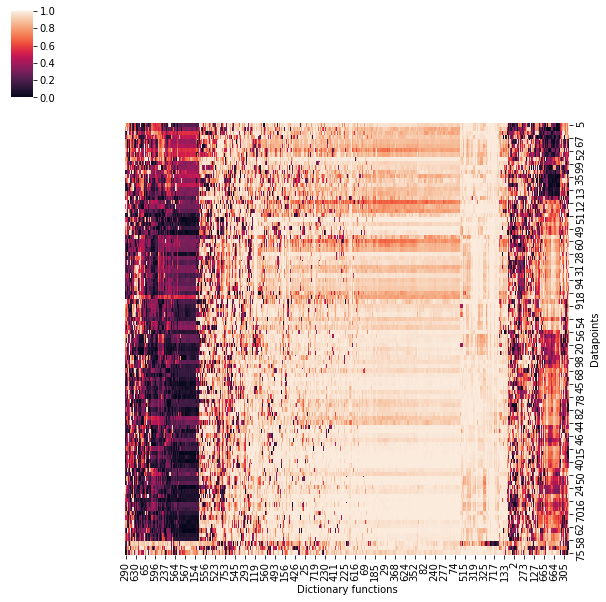

In [35]:
ax = sns.clustermap(np.abs(coses))
ax.ax_col_dendrogram.set_visible(False)
ax.ax_row_dendrogram.set_visible(False)
ax.ax_heatmap.set_xlabel('Dictionary functions')
ax.ax_heatmap.set_ylabel('Datapoints')
#ax.ax_col_dendrogram.scatter(list(range(756)),coses.max(axis = 0))

In [41]:
coses.mean(axis = 0)

array([0.5283026 , 0.56890582, 0.47167083, 0.52458837, 0.56282393,
       0.5263864 , 0.49258658, 0.55158594, 0.45350889, 0.52184924,
       0.58547158, 0.56270745, 0.92777593, 0.9101882 , 0.92916169,
       0.92448424, 0.93083334, 0.93191556, 0.93284615, 0.91664766,
       0.93382162, 0.89900095, 0.93026137, 0.93125593, 0.93407397,
       0.90682227, 0.93448158, 0.92678022, 0.93380213, 0.93507912,
       0.23321811, 0.2308996 , 0.2860215 , 0.2331371 , 0.27771234,
       0.23323924, 0.71919567, 0.67378298, 0.68070178, 0.63796109,
       0.59893446, 0.68652087, 0.94460523, 0.93927066, 0.94406697,
       0.9427589 , 0.94286781, 0.9431211 , 0.94620822, 0.93943446,
       0.94624206, 0.93741677, 0.94750479, 0.94692726, 0.94991809,
       0.93828701, 0.94884534, 0.94595484, 0.94998056, 0.94835794,
       0.36696531, 0.23991564, 0.33255382, 0.28055602, 0.27531944,
       0.39262028, 0.94378425, 0.93148949, 0.94426663, 0.93168081,
       0.94436631, 0.94396025, 0.94516359, 0.93501437, 0.94579

In [153]:
coses.shape

(100, 756)

In [154]:
keepers

array([175, 212, 234, 238, 449, 568])

In [133]:
incoherent_indices

array([722., 234.])

In [127]:
#     incoherent_indices = []

#     #dg_M_down = 
#     keepers = np.asarray(list(range(dg_M.shape[2])))
#     for i in range(100):
        
#         id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
#         ind_add = keepers[id_add]
#         incoherent_indices = np.append(incoherent_indices, ind_add)
        
#         #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
#         coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]
#         keepers = keepers[np.where(np.max(np.abs(coses), axis = 0) < thresh)[0]]
#         #print(keepers)
#         if len(keepers) == 0:
#             break
#     coses.mean(axis = 0).argmin()
#     np.where(coses[:,55] > .8)

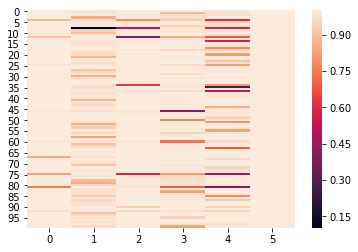

In [128]:
sns.heatmap(coses)

In [ ]:
get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]

In [46]:
# def get_incoherent_dictionary2(dg_M, thresh):
    
#     incoherent_indices = np.asarray([], dtype = int)

#     #dg_M_down = 
#     keepers = np.asarray(list(range(dg_M.shape[2])))
#     for i in range(100):
#         print(i)
#         id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
#         ind_add = keepers[id_add]
#         incoherent_indices = np.append(incoherent_indices, ind_add)
        
#         #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
#         coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, incoherent_indices)
#         cos_max = np.min(coses, axis = 1)
#         keepers = np.where(cos_max < thresh)[0]
#         print(keepers)
#         if len(keepers) == 0:
#             break
            
#     return(np.asarray(incoherent_indices, dtype = int))

In [159]:
    incoherent_indices = np.asarray([], dtype = int)

    #dg_M_down = 
    keepers = np.asarray(list(range(dg_M.shape[2])))


In [160]:
        id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        ind_add = keepers[id_add]
        incoherent_indices = np.append(incoherent_indices, ind_add)


In [91]:
incoherent_indices

NameError: name 'incoherent_indices' is not defined

In [162]:
        coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, incoherent_indices)
        cos_max = np.min(coses, axis = 1)
        keepers = np.where(cos_max < thresh)[0]

        

In [ ]:
    for i in range(100):
        
        id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        ind_add = keepers[id_add]
        incoherent_indices = np.append(incoherent_indices, ind_add)
        
        #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, incoherent_indices)
        cos_max = np.min(coses, axis = 1)
        keepers = np.where(cos_max < thresh)[0]
        print(keepers)
        if len(keepers) == 0:
            break


In [153]:
keepers

array([], dtype=int64)

In [151]:
get_incoherent_dictionary2(dg_M, .8)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [143]:
    incoherent_indices = []

    #dg_M_down = 
    keepers = np.asarray(list(range(dg_M.shape[2])))
    for i in range(100):
        
        id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        ind_add = keepers[id_add]
        incoherent_indices = np.append(incoherent_indices, ind_add)
        
        #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]
        keepers = keepers[np.where(np.max(np.abs(coses), axis = 0) < thresh)[0]]
        print(keepers)
        if len(keepers) == 0:
            break


[ 61  85  88 150 152 153 154 155 174 175 176 178 179 204 206 208 209 210
 212 214 215 234 235 236 238 309 360 361 364 365 445 449 565 566 567 568
 569 584 585 586 595 596 597 598 603 604 621 630 631 632 633 634 638 639
 640 649 652 662 663 692]
[]


In [144]:
coses

array([[ 0.0916521 ,  0.88648315, -0.9016023 , ...,  0.65800036,
        -0.64975632,  0.51323231],
       [ 0.87534891,  0.7561934 , -0.86274228, ...,  0.57267335,
        -0.60206671,  0.96753782],
       [ 0.97978553,  0.80115184, -0.74285608, ...,  0.56244394,
        -0.57937506,  0.99635052],
       ...,
       [-0.99997487,  0.99642729, -0.99174769, ...,  0.96136889,
        -0.96193323,  0.91624546],
       [ 0.80687453,  0.99489051, -0.99927604, ..., -0.7827983 ,
         0.78344342,  0.96059093],
       [ 0.97216362,  0.99913608, -0.99970033, ..., -0.23048376,
         0.19398758,  0.89810726]])

In [136]:
incoherent_indices = get_incoherent_dictionary(replicates[0].dg_M, .98)

[ 61  85  88 150 152 153 154 155 174 175 176 178 179 204 206 208 209 210
 212 214 215 234 235 236 238 309 360 361 364 365 445 449 565 566 567 568
 569 584 585 586 595 596 597 598 603 604 621 630 631 632 633 634 638 639
 640 649 652 662 663 692]
[]


In [137]:
incoherent_indices

array([722, 584])

In [141]:
np.abs(get_cosines_full(np.swapaxes(dg_M[:,:,ics],1,2)*n)[:,0,2]).max()

0.967250251377553

In [125]:
ics = np.asarray(incoherent_indices)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


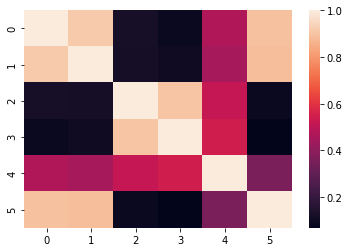

In [123]:
sns.heatmap(get_cosines(np.swapaxes(dg_M[:,:,incoherent_indices],1,2)*n))

In [58]:
coses = get_cos(np.swapaxes(dg_M,1,2)*n, [incoherent_indices])[:,0,:]

0

In [25]:
coses = get_cos_full_ind(np.swapaxes(dg_M,1,2)*n, [722])[:,0,:]

In [37]:
keepers = np.where(np.abs(np.max(coses, axis = 0)) < .8)[0]

In [40]:
ind2 = np.linalg.norm(dg_M, axis = tuple([0,1]))[keepers].argmax()

In [41]:
keepers[ind2]

721

In [42]:
coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [ind2])[:,0,:]

In [44]:
keepers2 = np.where(np.abs(np.max(coses, axis = 0)) < .8)[0]

In [46]:
ind3 = np.linalg.norm(dg_M, axis = tuple([0,1]))[keepers2].argmax()

In [47]:
ind3

0

In [48]:
keepers2

array([21])

In [ ]:

min_mins = np.zeros(5, dtype = np.float64)
mus = np.zeros(5, dtype = np.float64)
kappas = np.zeros(5, dtype = np.float64)
gamma_maxs = np.zeros(5, dtype = np.float64)
n = 100
for r in range(5):
    print(r)
    inds = sel[r]
    dg_M = replicates[r].dg_M
    mus[r] = get_mu_full_ind(np.swapaxes(dg_M,1,2)*n, inds)

    